In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# need to install PyMaxflow (https://pmneila.github.io/PyMaxflow)
import maxflow


In [15]:
def binary_img_denoiser(img, rho=0.35, pairwise_cost_same=0.01, pairwise_cost_diff=0.5):
    """

    :param img:
    :param rho:
    :param pairwise_cost_same:
    :param pairwise_cost_diff:
    :return:
    """
    # 1) Define Graph
    g = maxflow.Graph[float]()
    
    # 2) Add pixels as nodes
    row, col = img.shape  
    nodeids = g.add_grid_nodes((row, col))

    
    # 3) Compute Unary cost
    unary_cost_source = img.copy() / 255

    unary_cost_source[unary_cost_source == 0] = -np.log(rho)
    unary_cost_source[unary_cost_source == 1] = -np.log(1 - rho)

    unary_cost_sink = img.copy() / 255

    unary_cost_sink[unary_cost_sink == 0] = -np.log(1 - rho)
    unary_cost_sink[unary_cost_sink == 1] = -np.log(rho)

    # 4) Add terminal edges
    g.add_grid_tedges(nodeids, unary_cost_source, unary_cost_sink)

    # 5) Add Node edges
    pairwise_cost_vertical = np.zeros(img.shape)

    # Vertical Edges
    for i in range(img.shape[0]):
        for j in range(img.shape[1]-1):
            if unary_cost_sink[i][j] == unary_cost_sink[i][j+1] and unary_cost_source[i][j] == unary_cost_source[i][j+1]:
                pairwise_cost_vertical[i][j] = pairwise_cost_same
            else:
                pairwise_cost_vertical[i][j] = pairwise_cost_diff

    structure = np.array([[0, 1, 0], [0, 0, 0], [0, 1, 0]])
    g.add_grid_edges(nodeids, pairwise_cost_vertical, structure, symmetric=False) 

    # Horizontal edges
    # (Keep in mind the structure of neighbourhood and set the weights according to the pairwise potential)
    pairwise_cost_horizontal = np.zeros(img.shape)
    for i in range(img.shape[0]-1):
        for j in range(img.shape[1]):
            if unary_cost_sink[i][j] == unary_cost_sink[i+1][j] and unary_cost_source[i][j] == unary_cost_source[i+1][j]:
                pairwise_cost_horizontal[i][j] = pairwise_cost_same
            else:
                pairwise_cost_horizontal[i][j] = pairwise_cost_diff
    
    structure = np.array([[0, 0, 0], [1, 0, 1], [0, 0, 0]])
    g.add_grid_edges(nodeids, pairwise_cost_horizontal, structure, symmetric=False) 

    # 6) Maxflow
    g.maxflow()
    sgm = g.get_grid_segments(nodeids)
    # img2 = np.int_(np.logical_not(sgm))
    img2 = sgm
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title("Denoised with diff = {} and same = {} ".format(pairwise_cost_diff, pairwise_cost_same))
    plt.axis('off')
    


C:\Users\vadim\AppData\Local\Temp\ipykernel_9652\3938868283.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


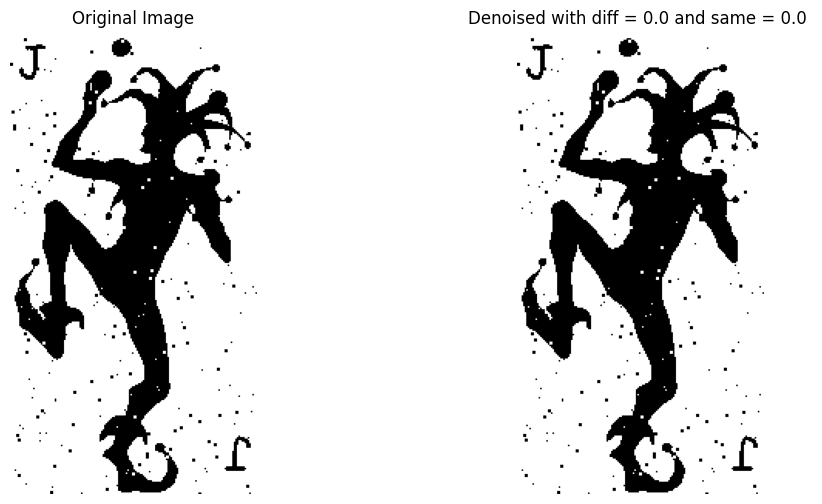

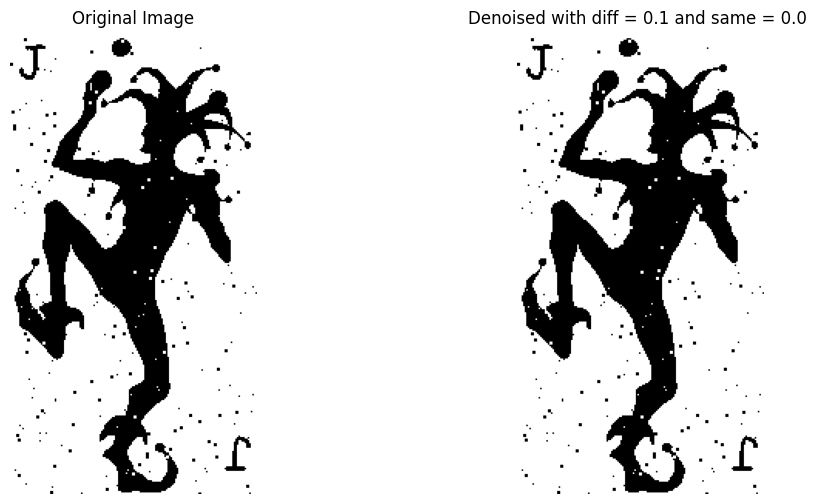

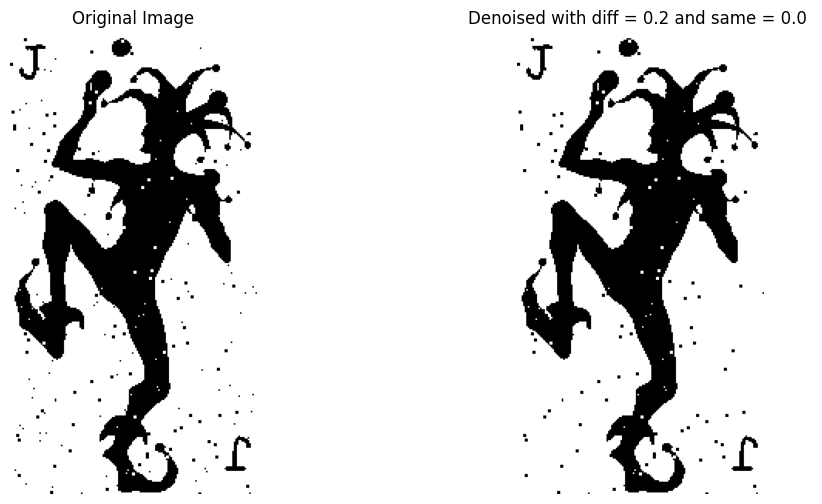

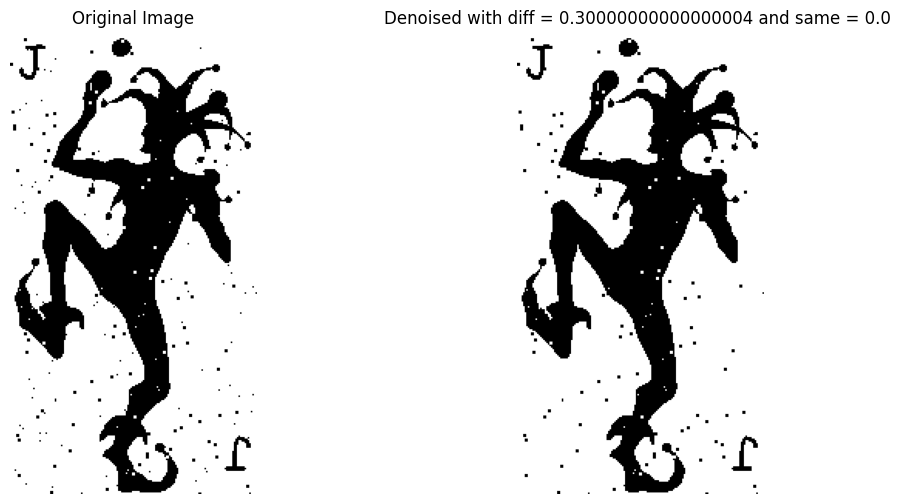

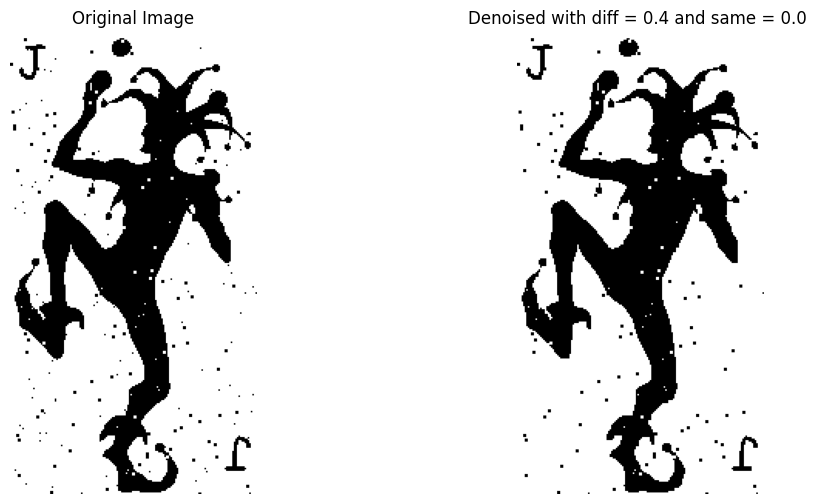

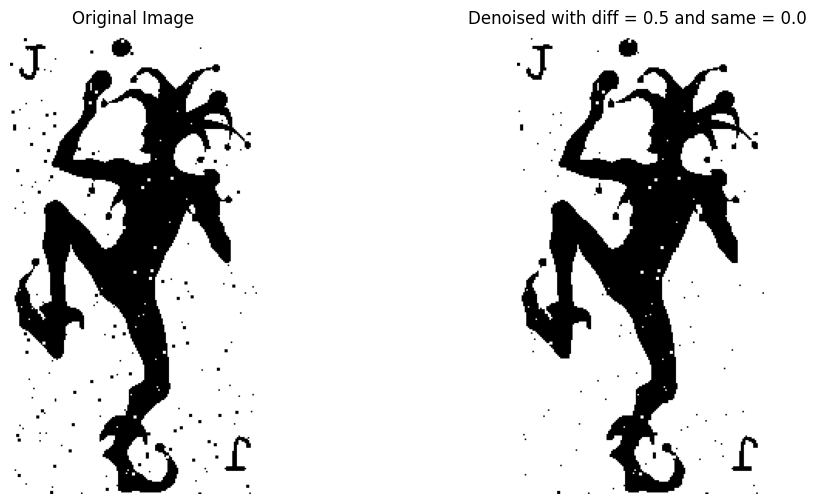

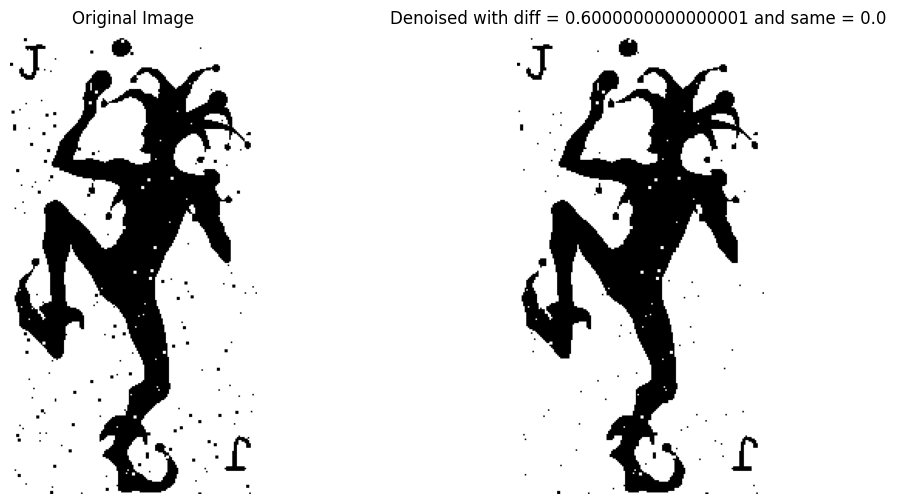

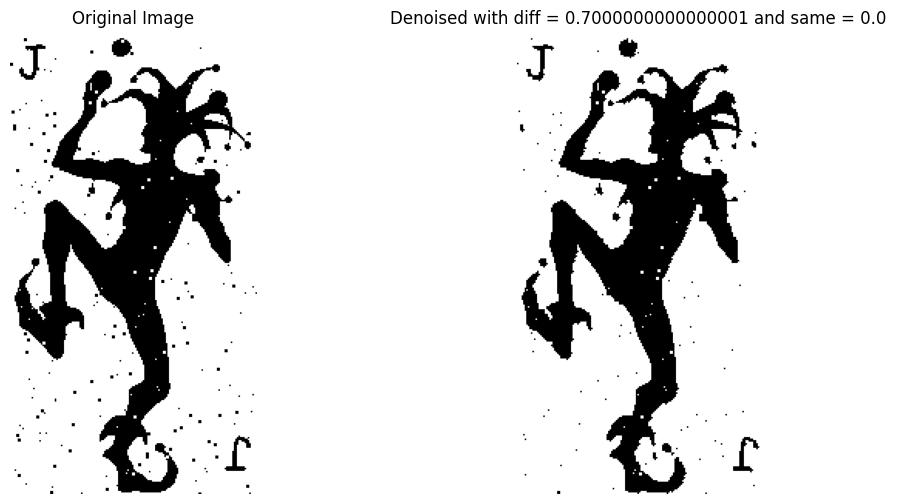

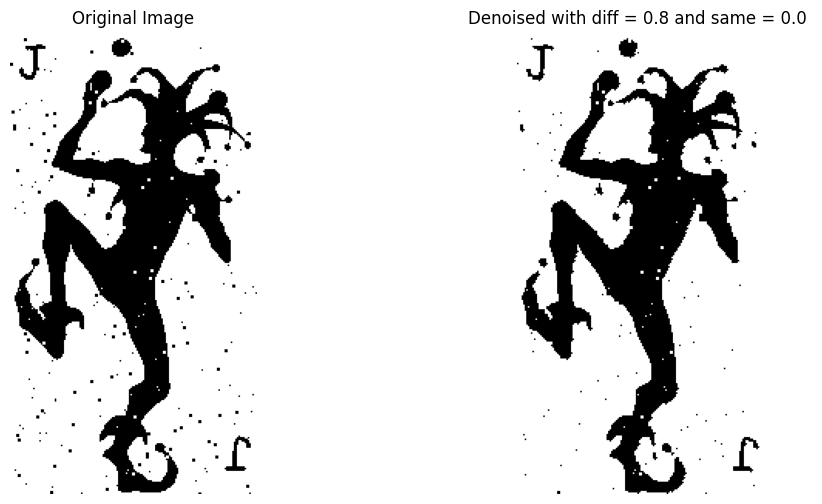

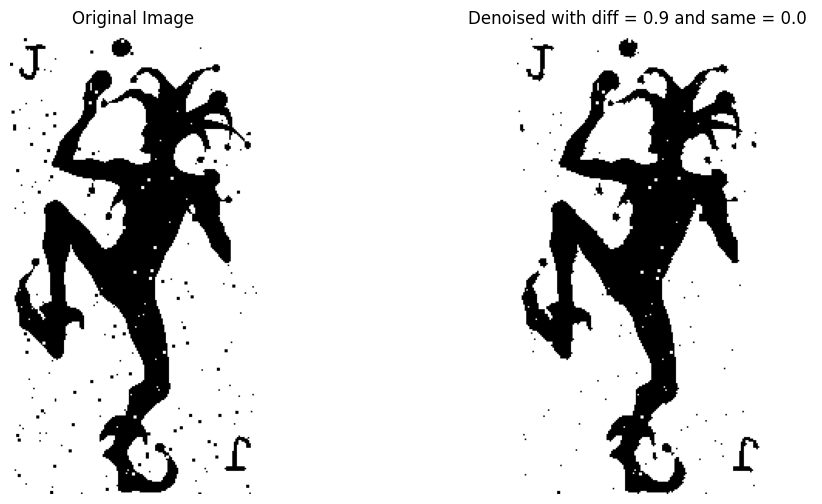

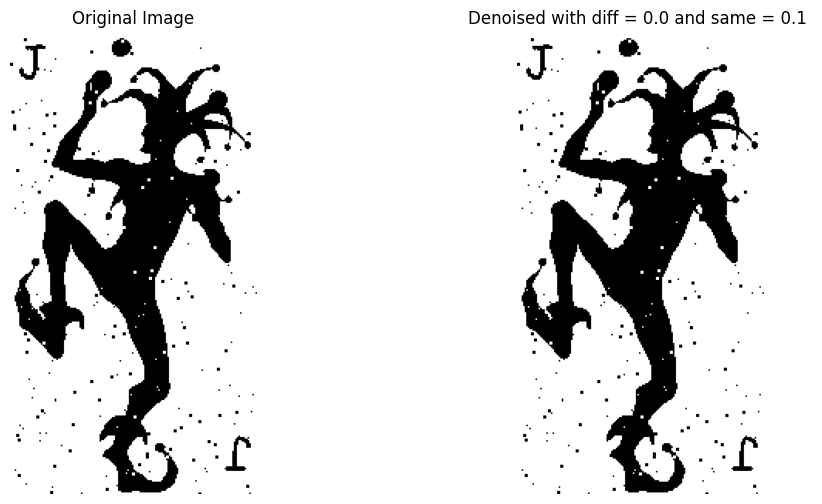

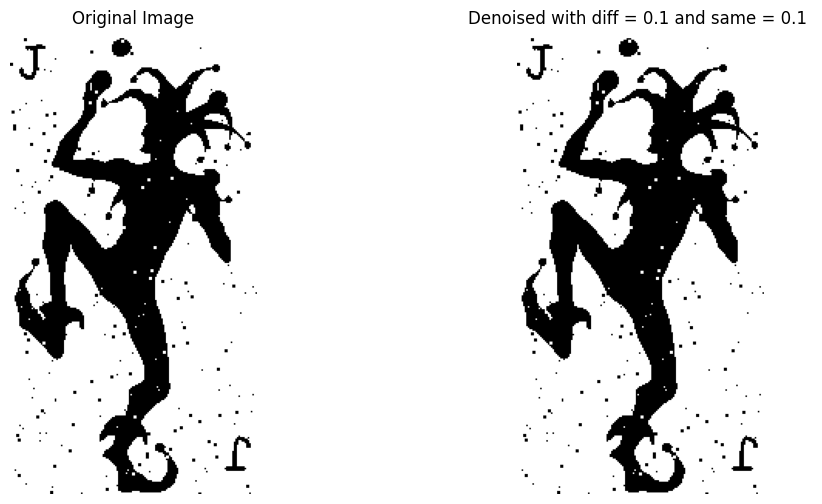

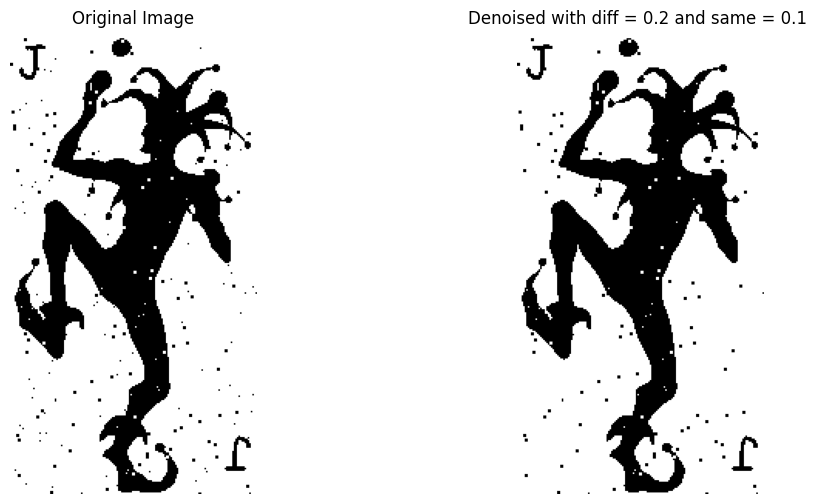

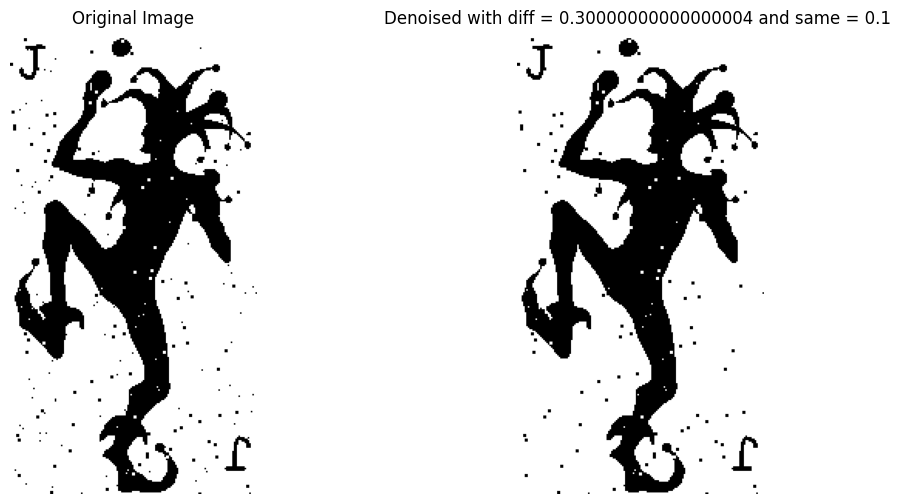

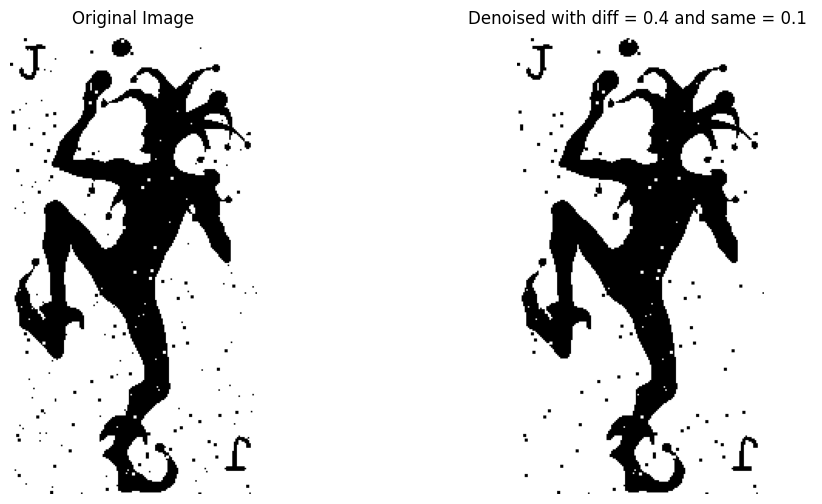

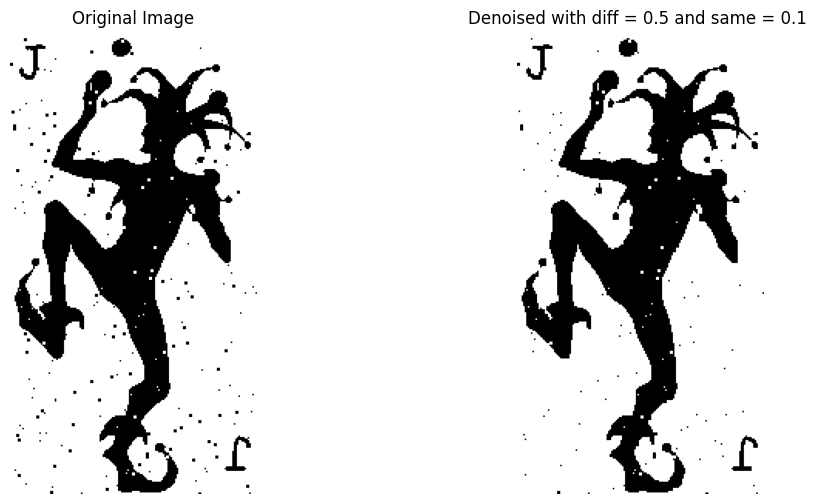

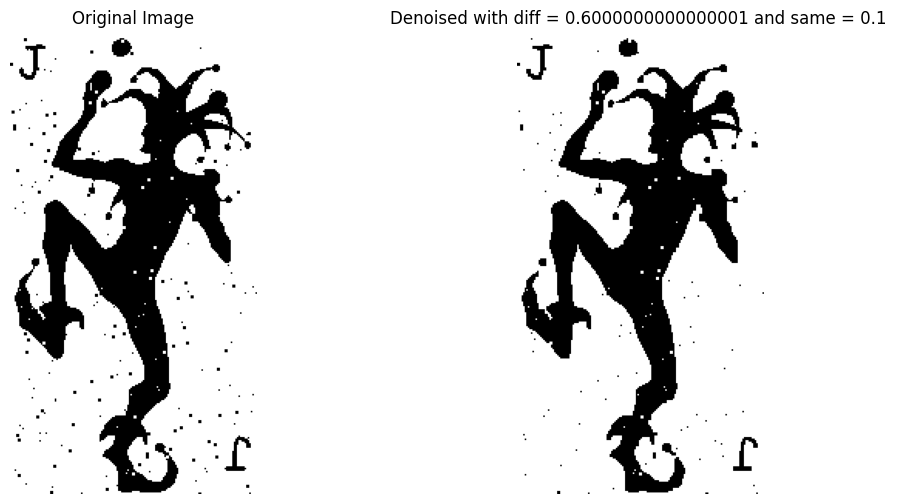

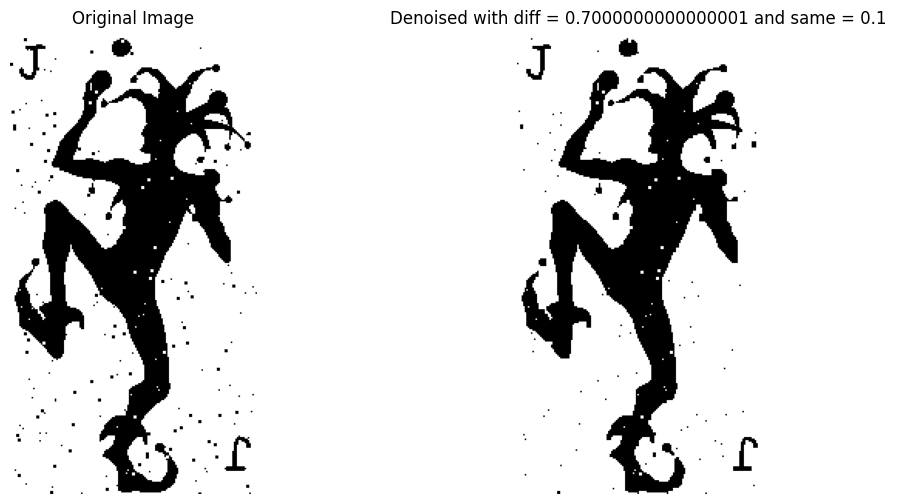

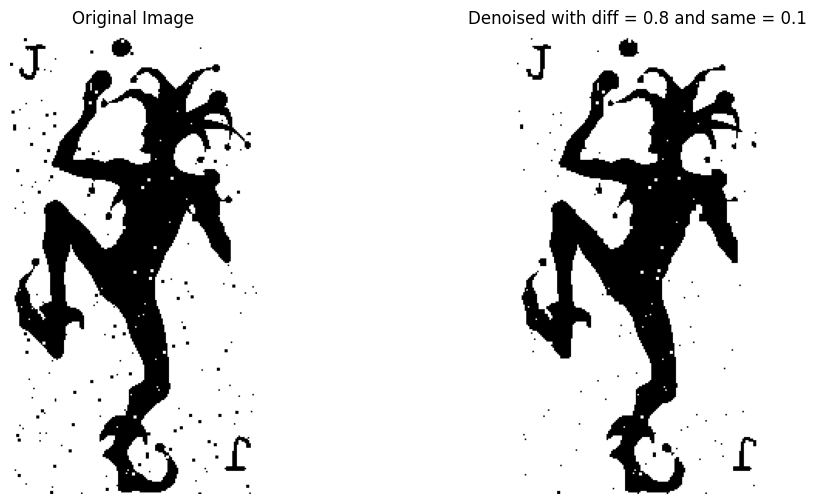

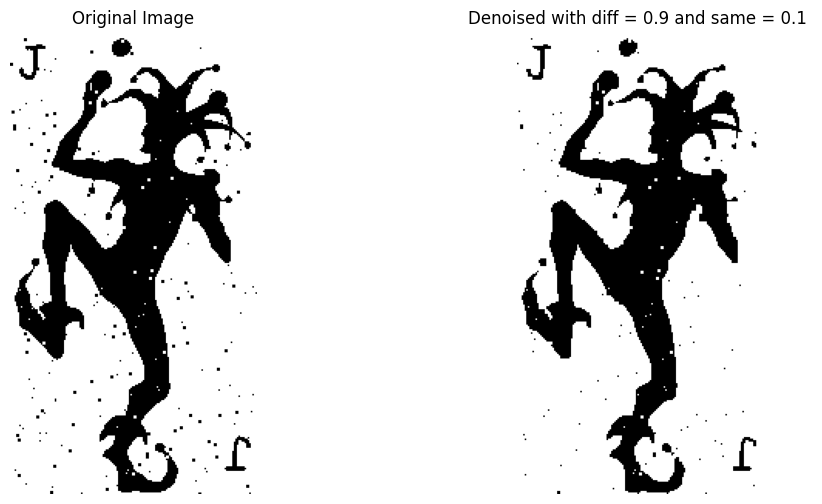

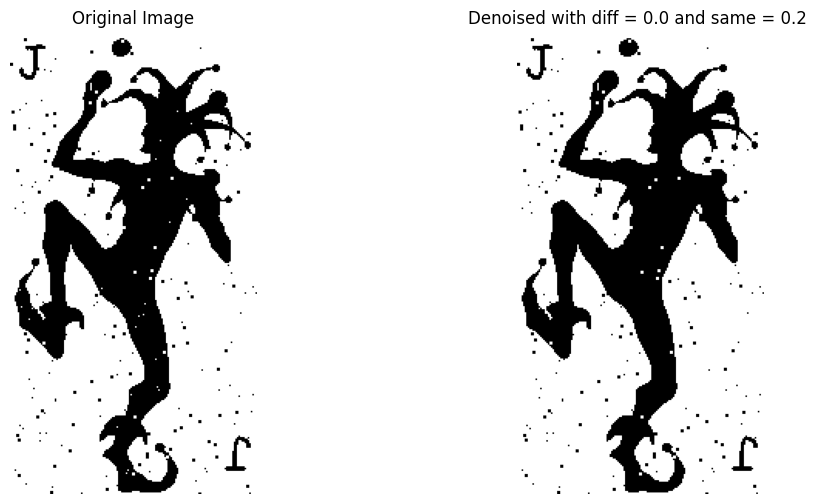

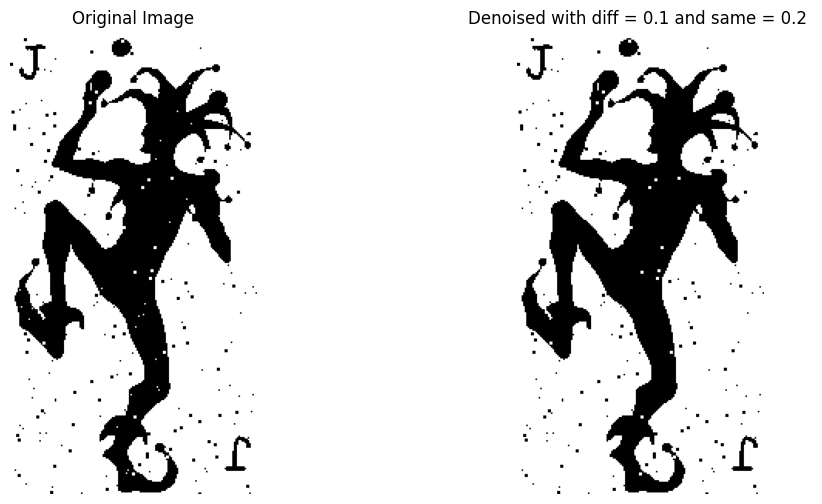

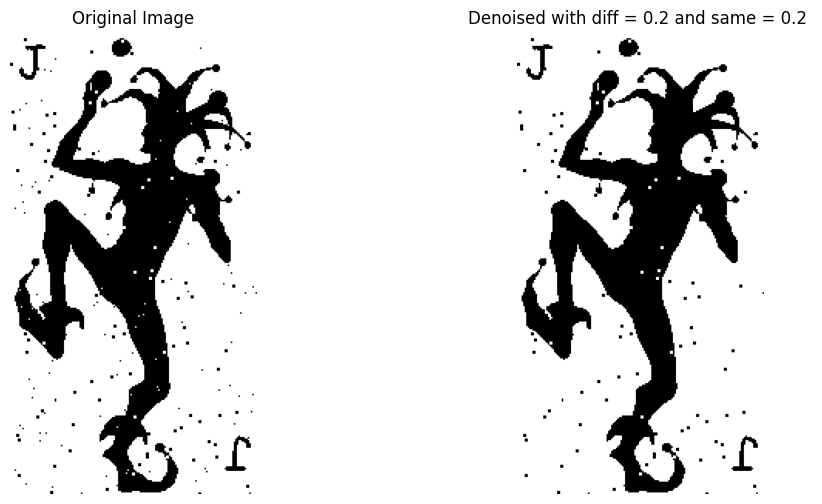

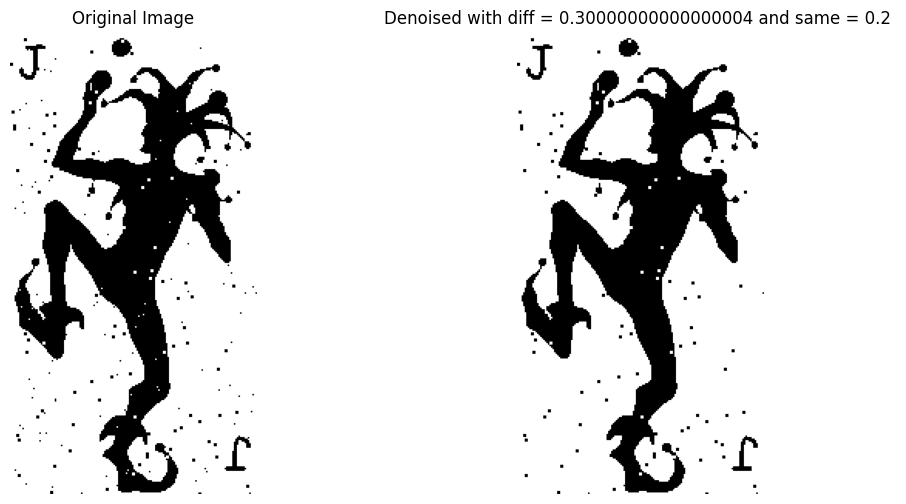

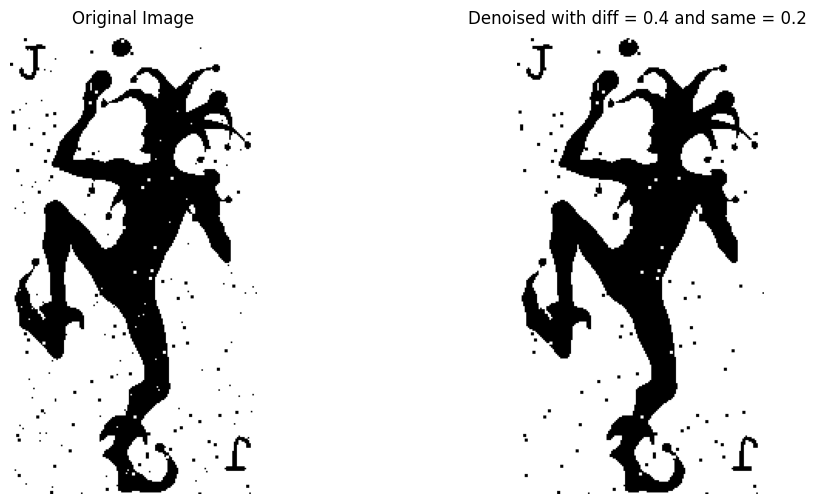

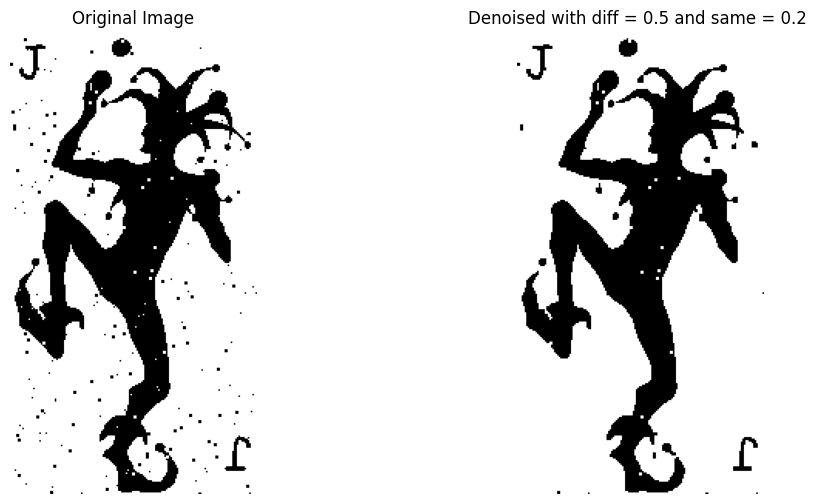

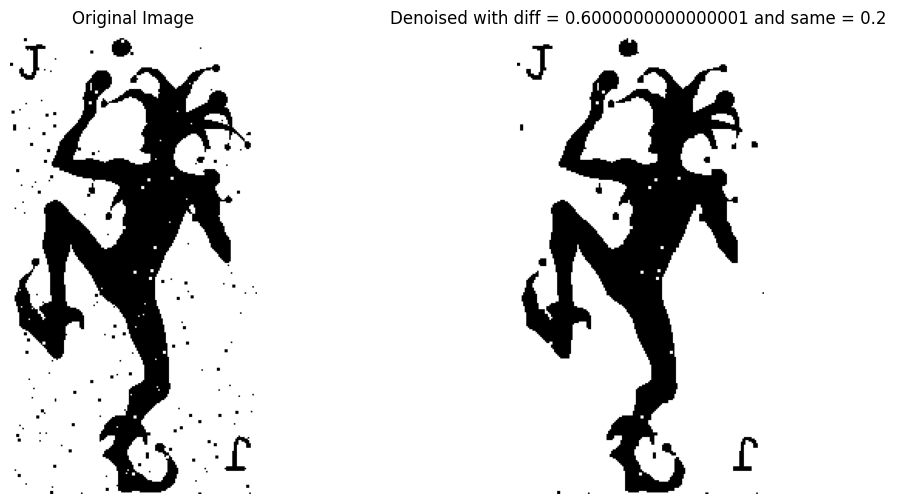

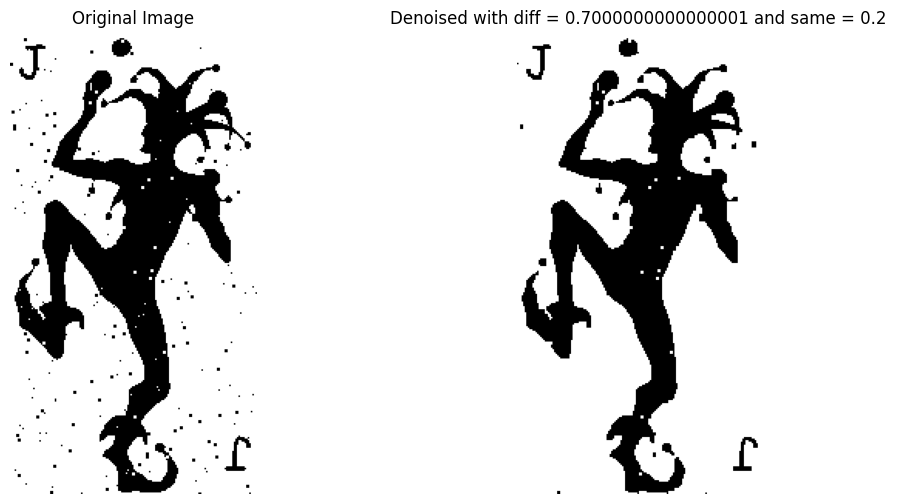

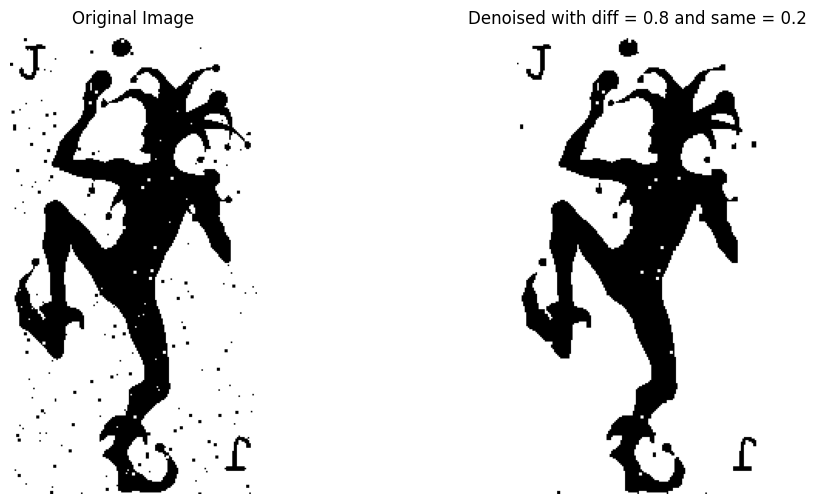

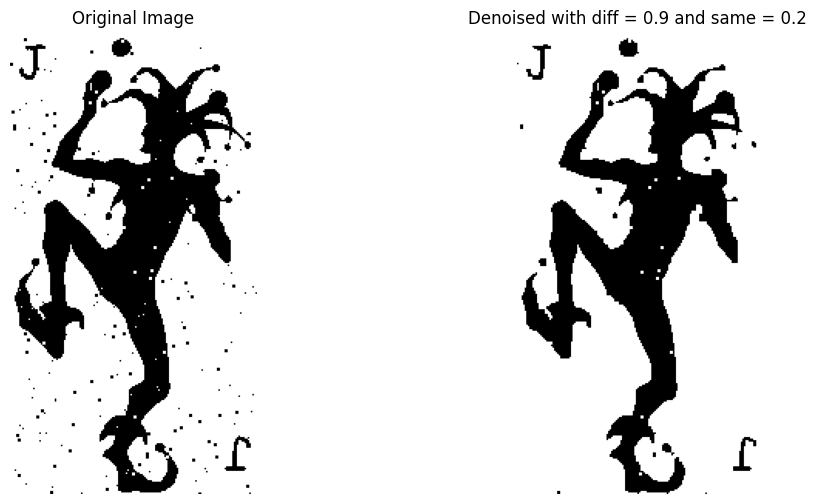

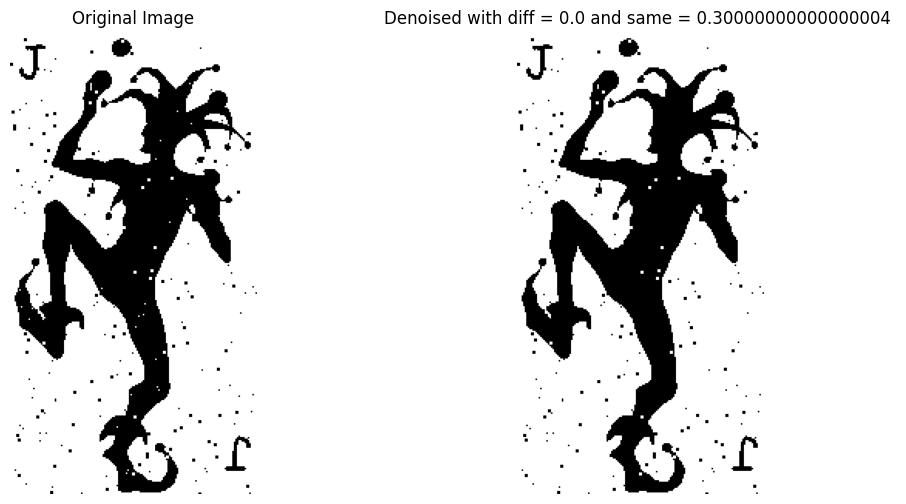

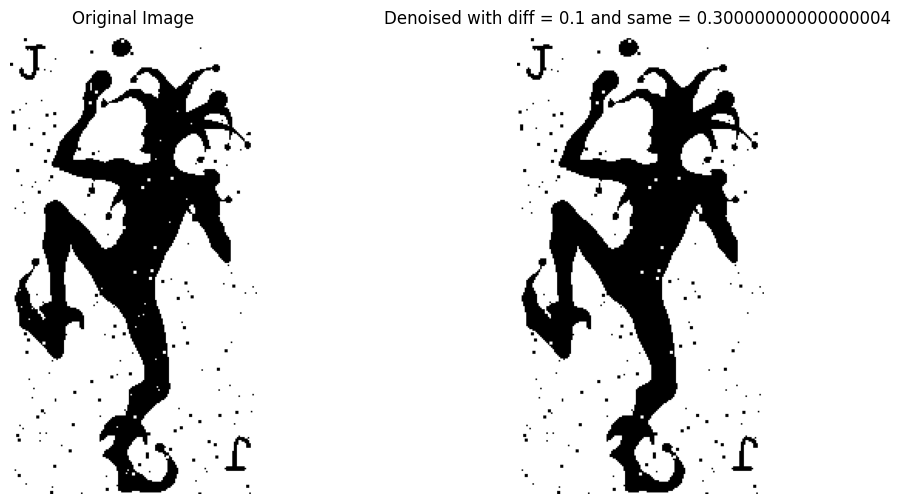

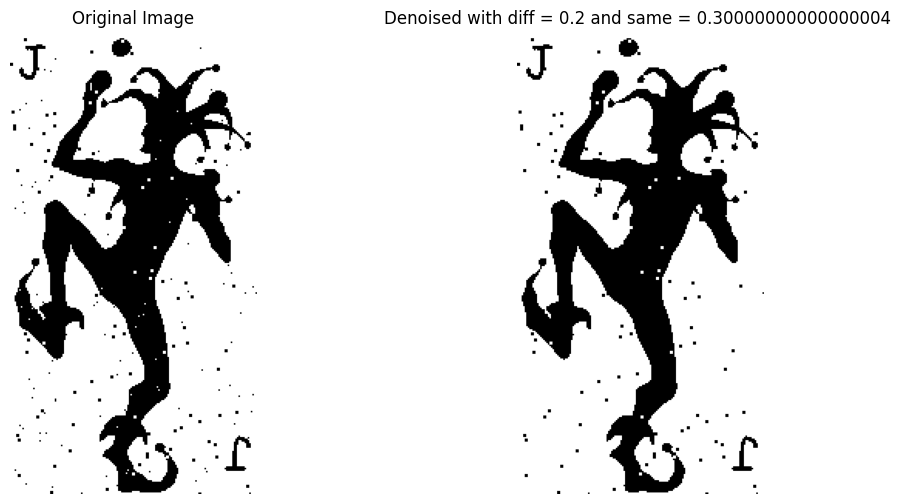

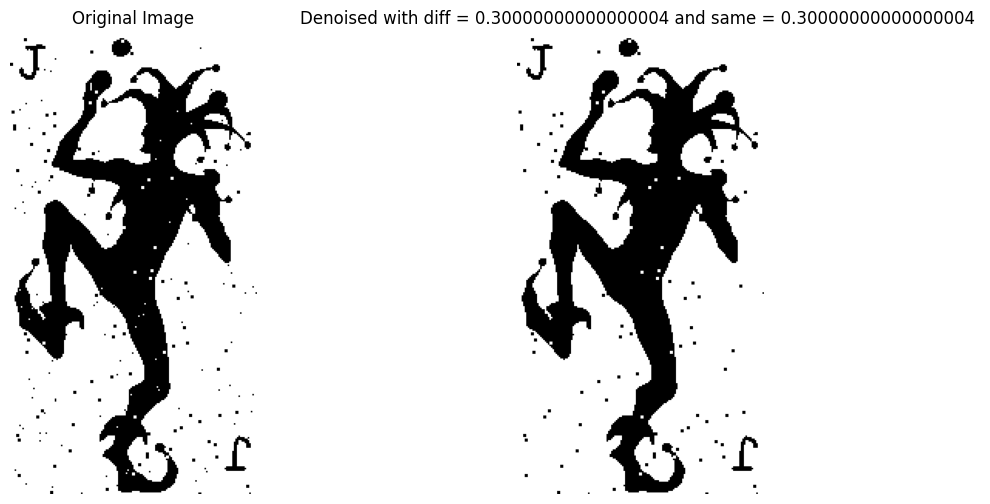

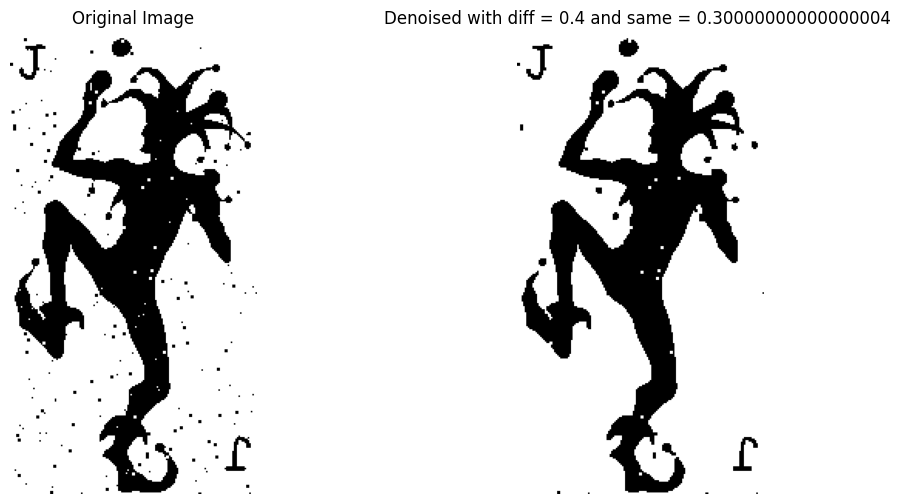

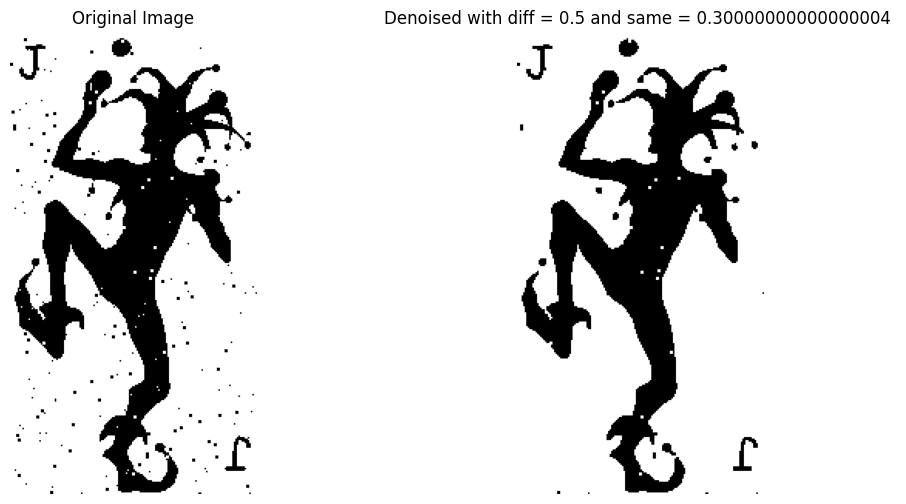

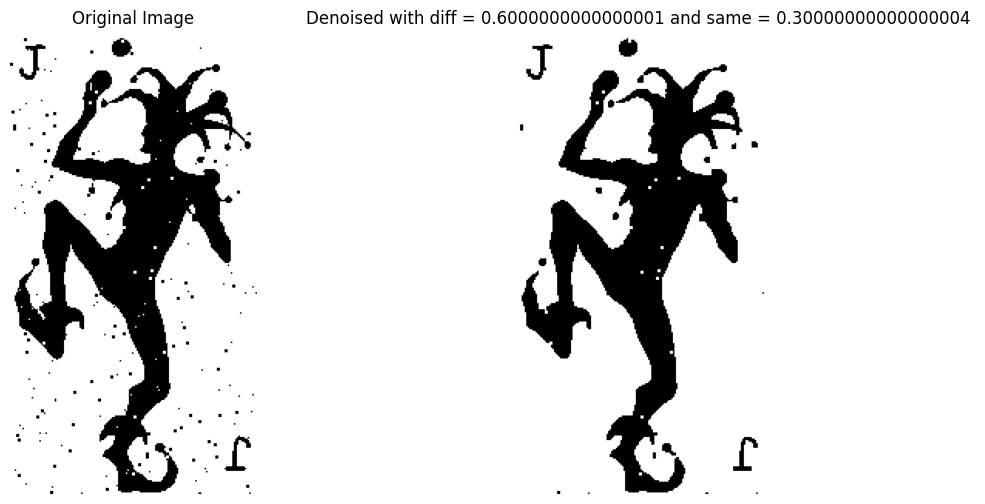

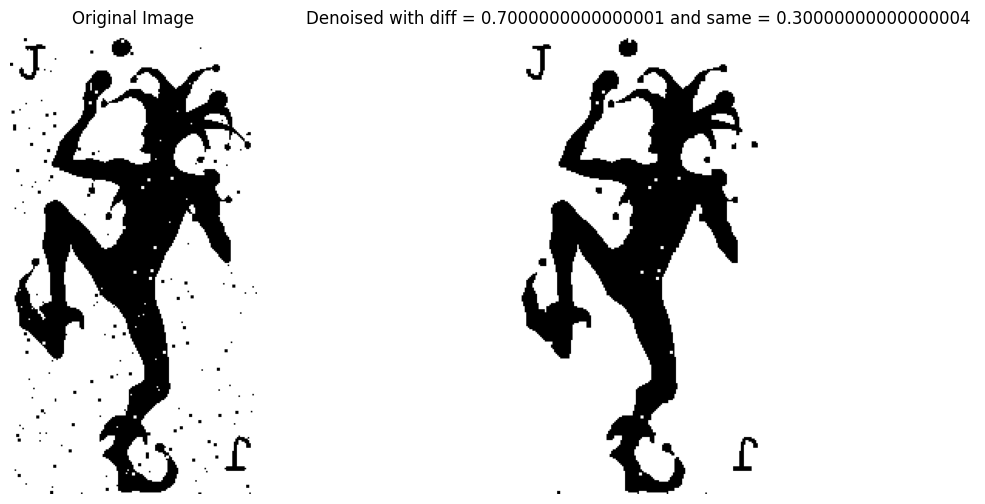

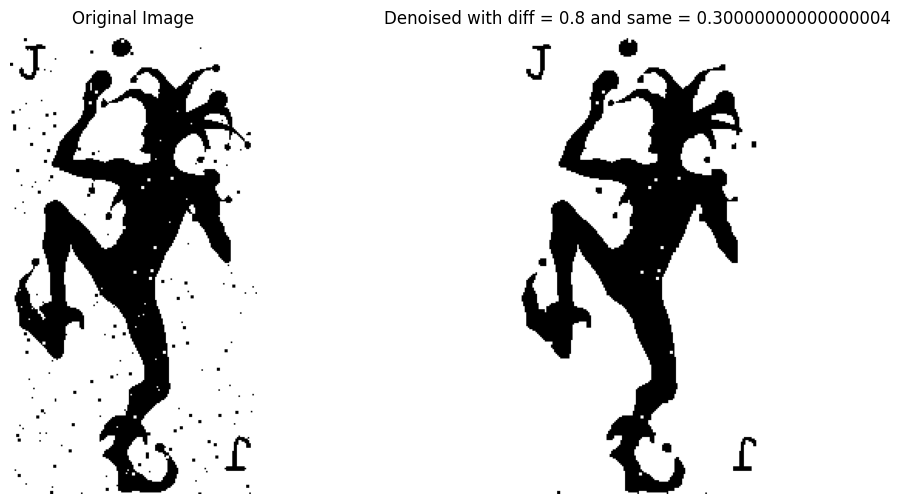

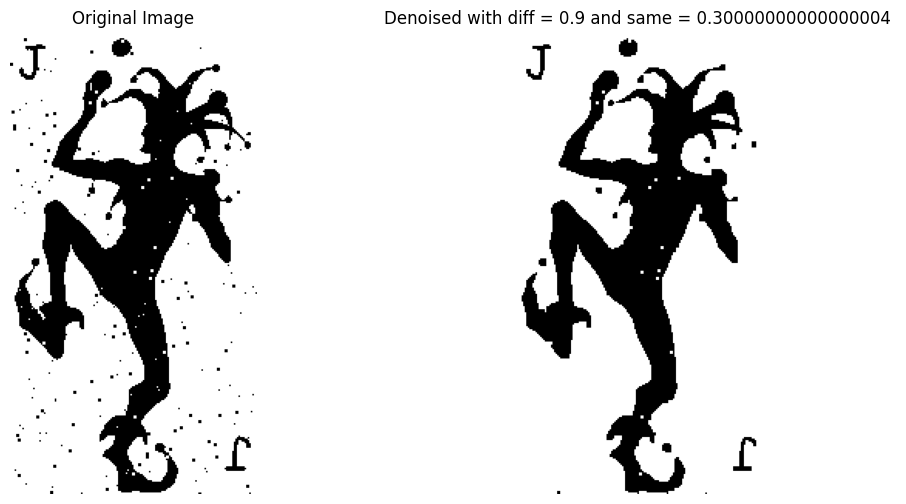

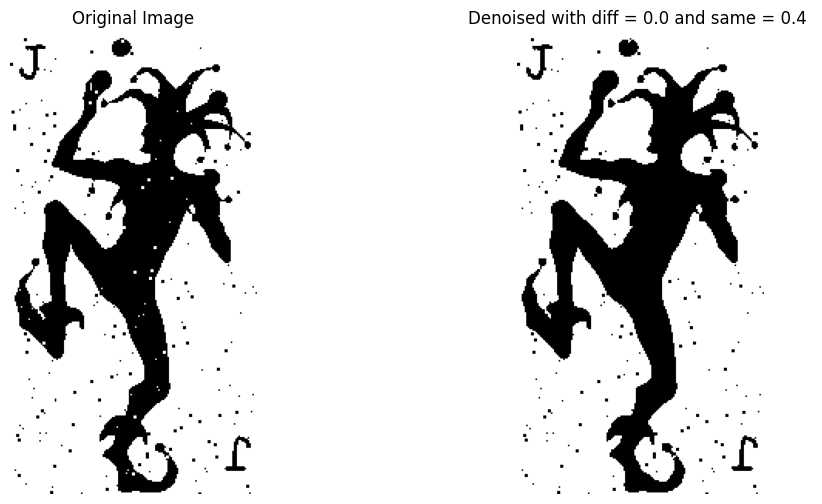

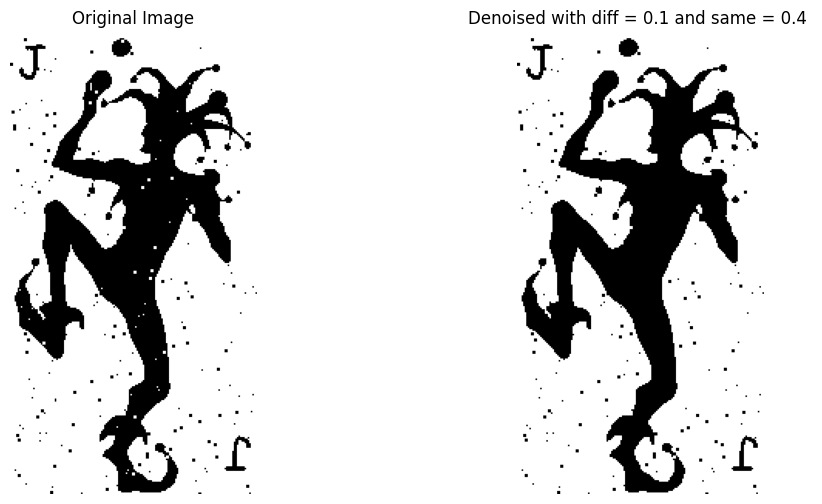

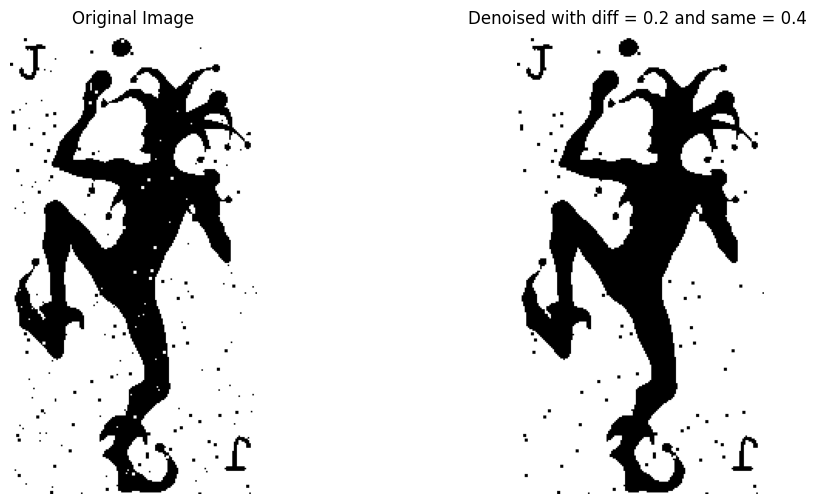

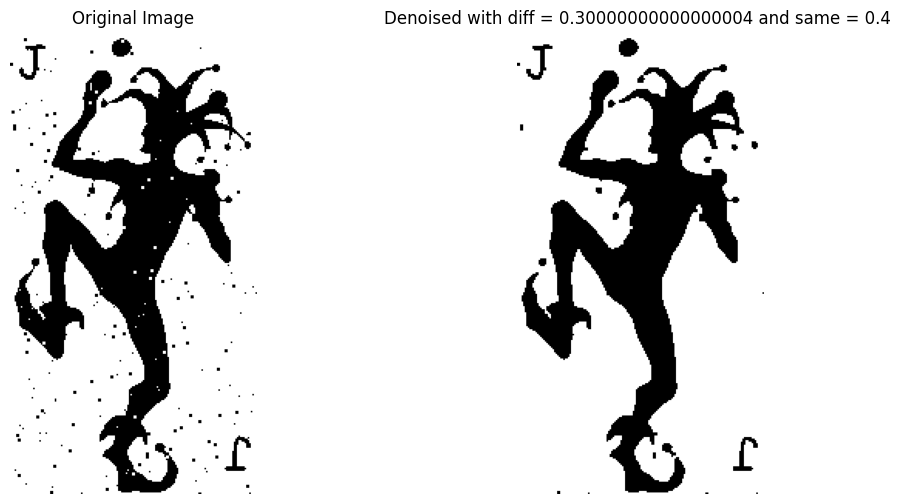

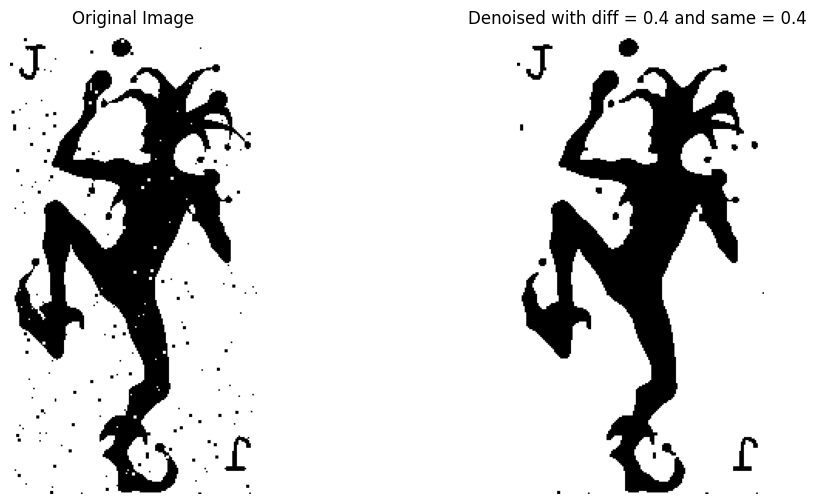

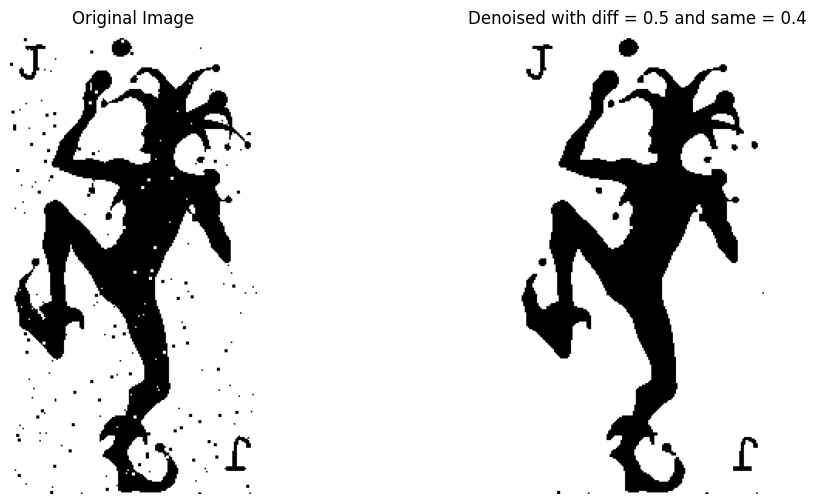

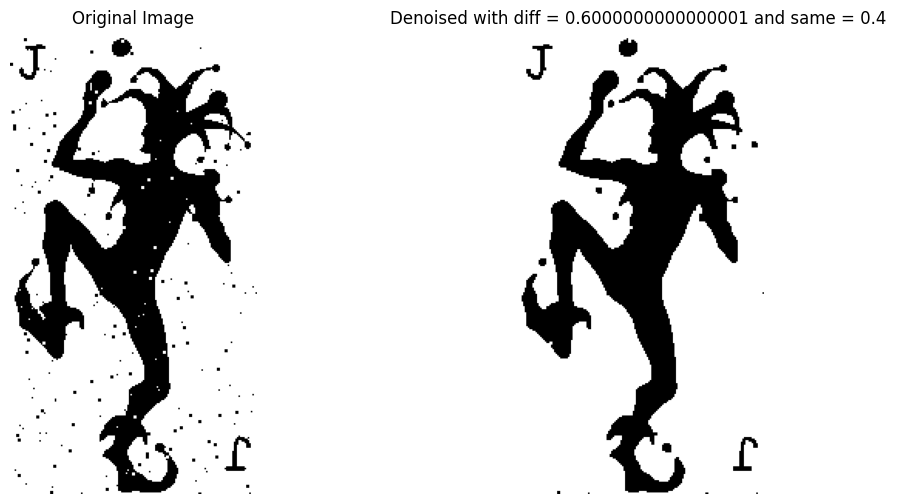

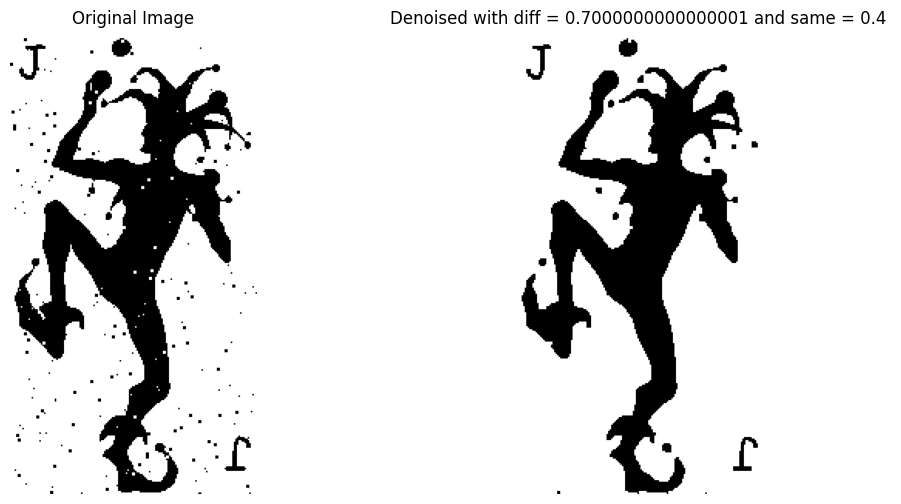

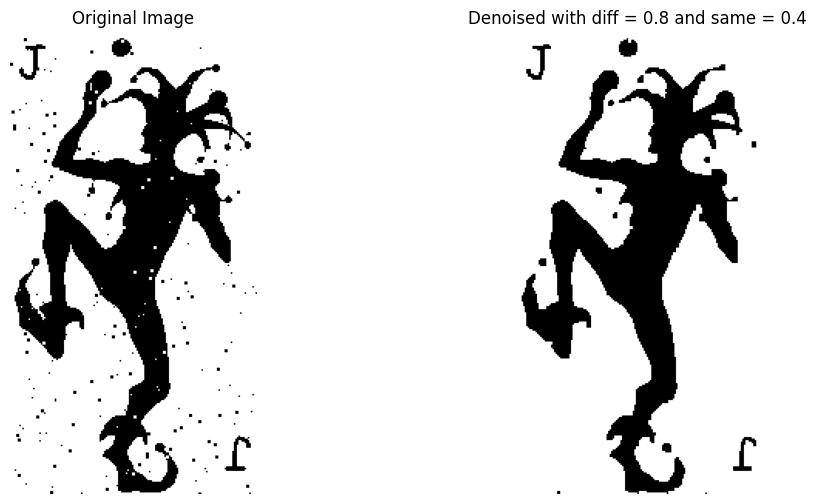

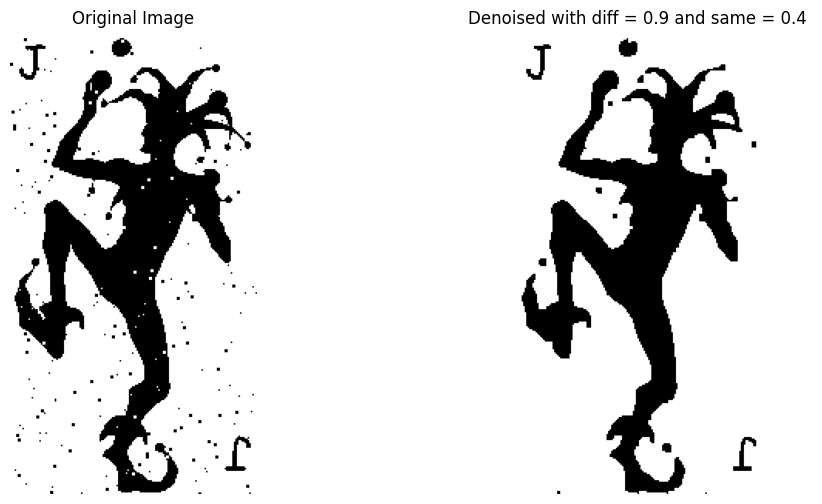

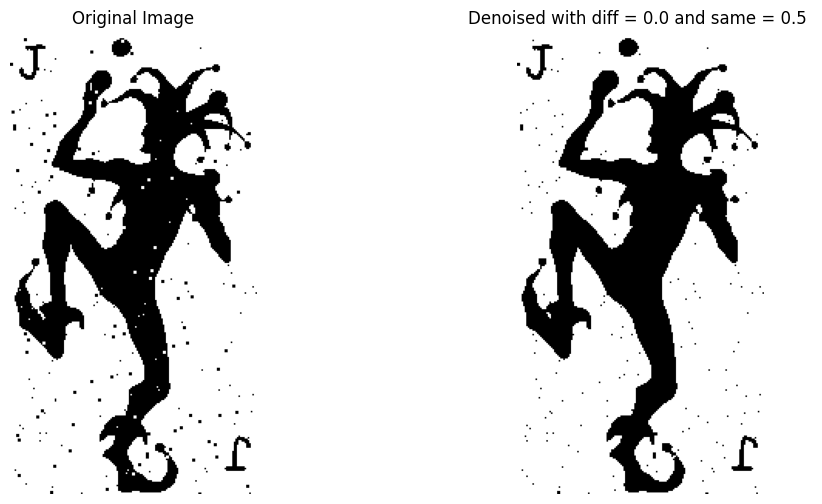

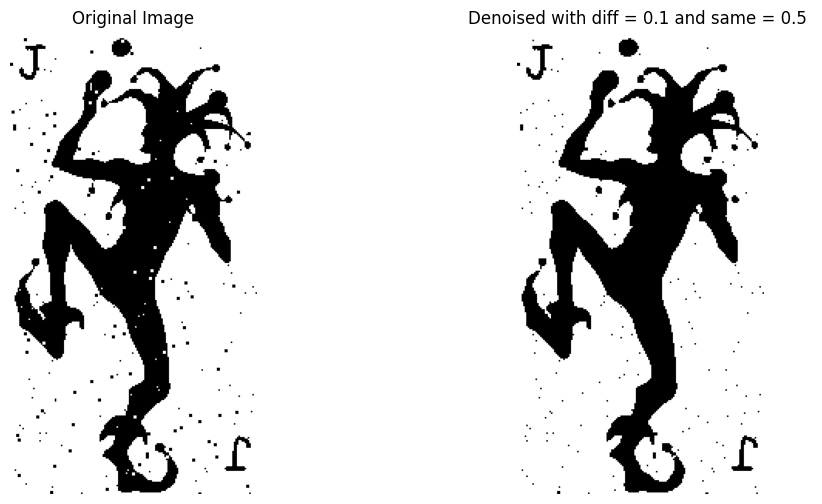

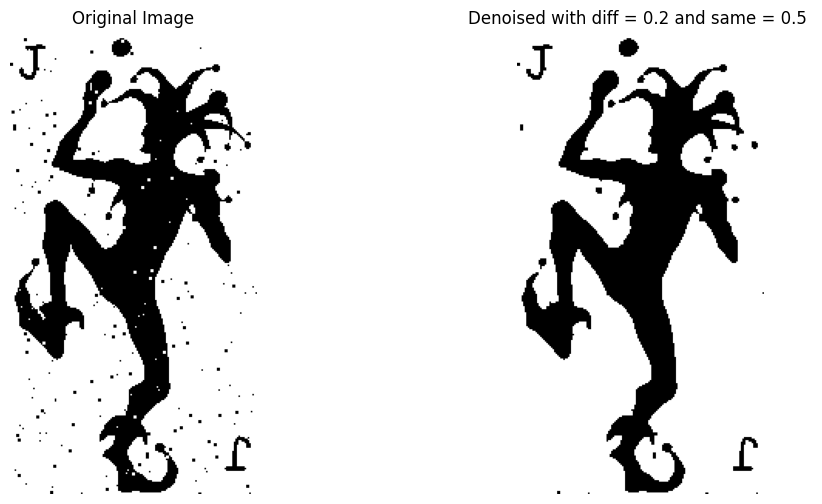

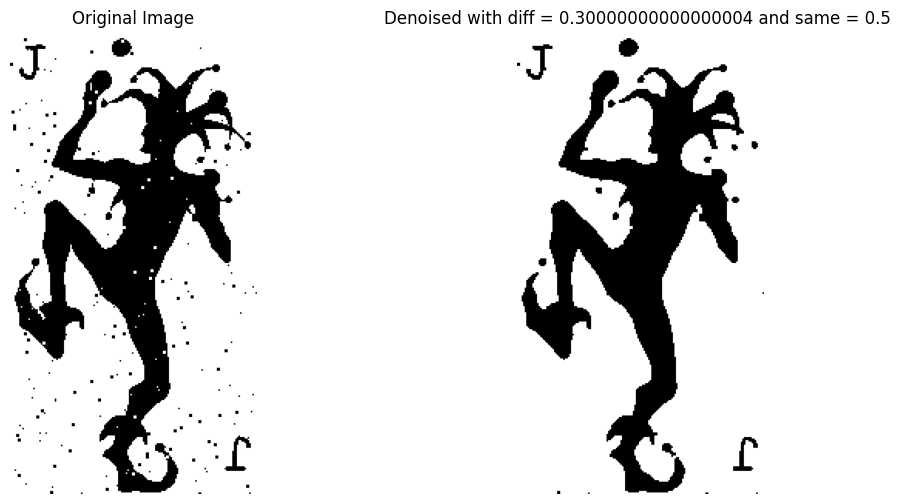

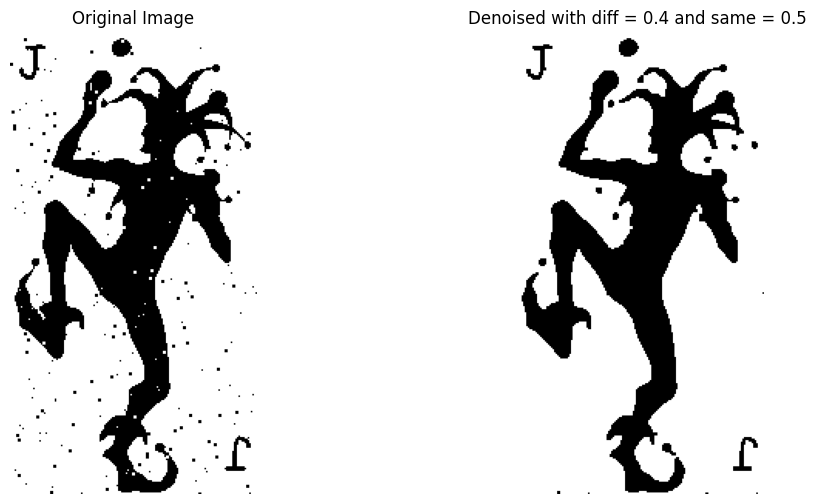

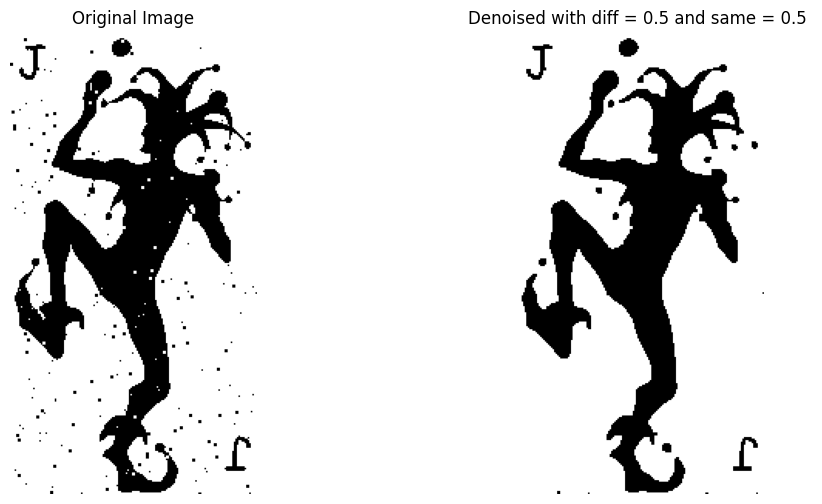

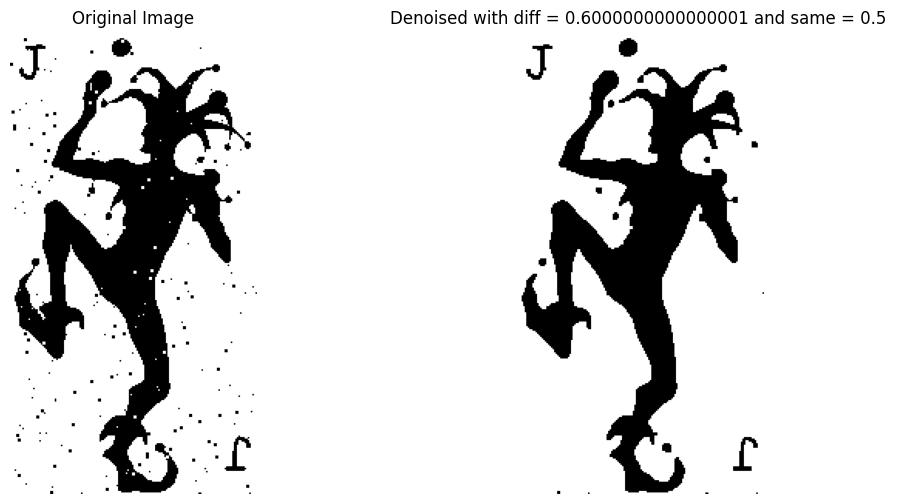

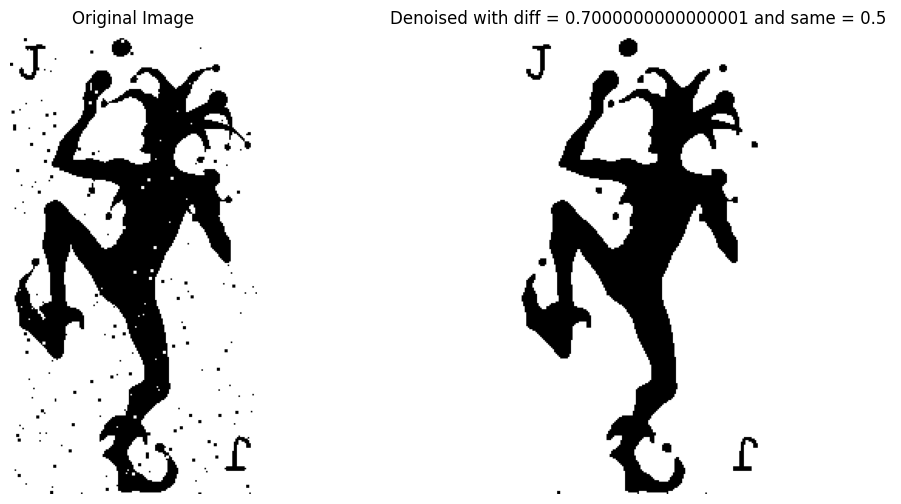

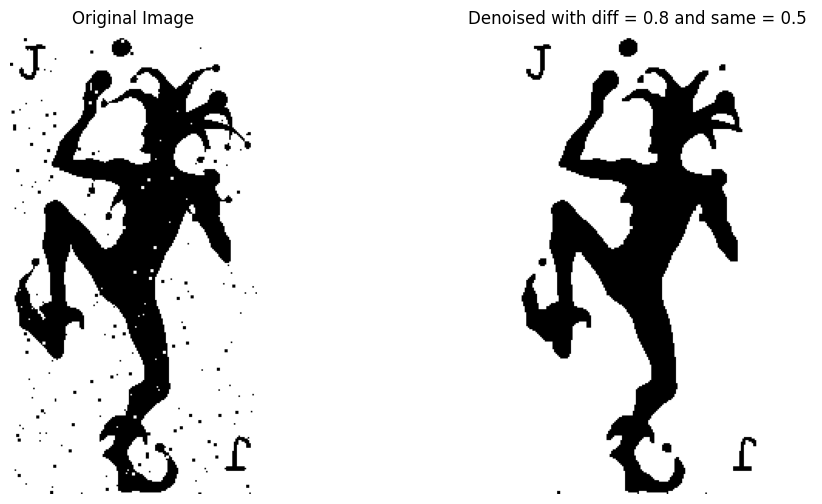

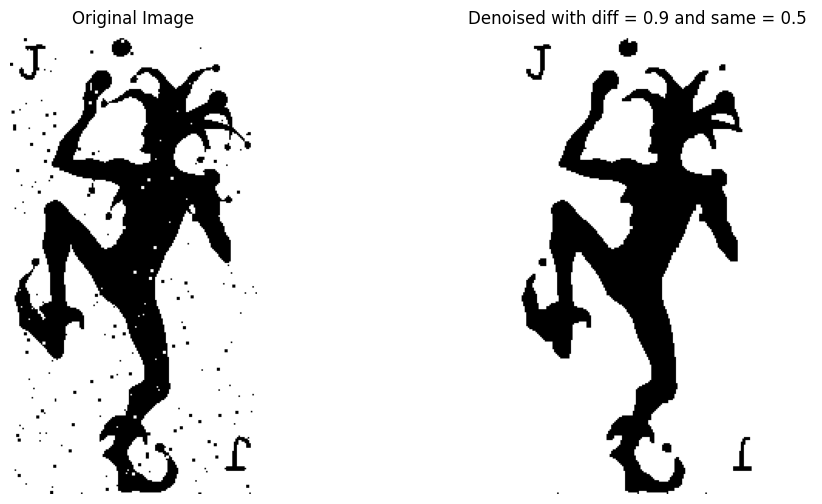

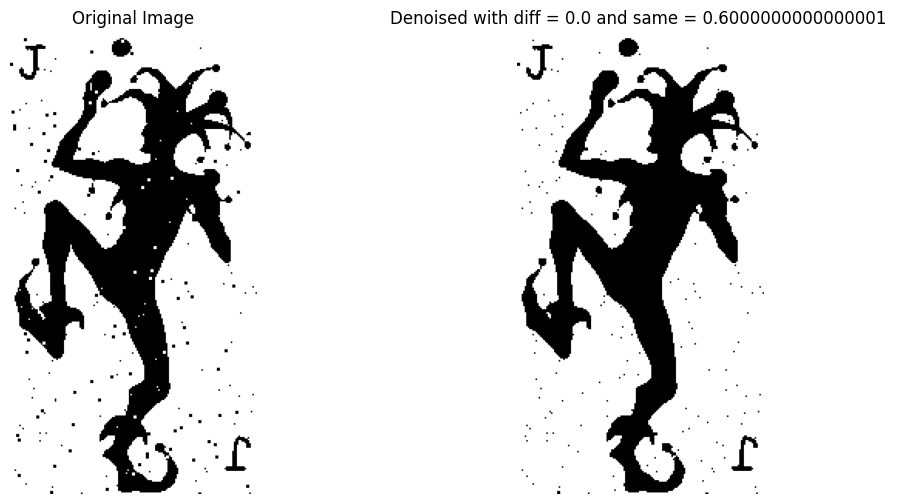

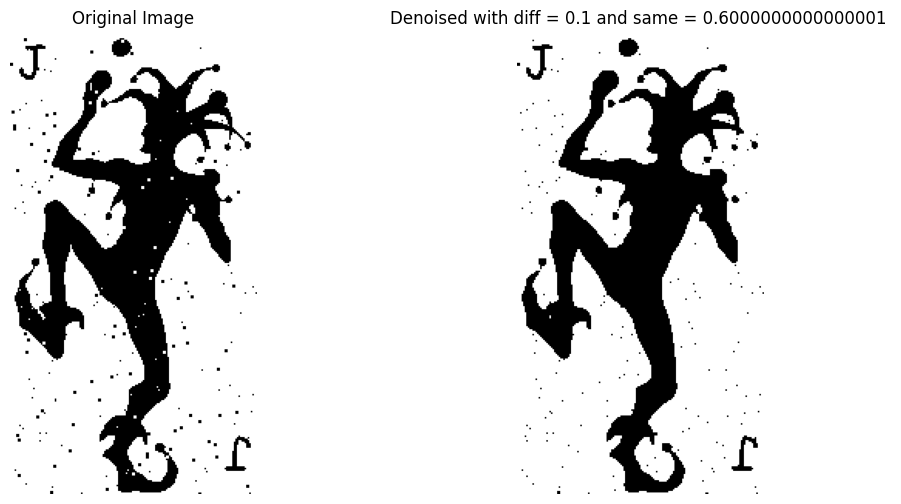

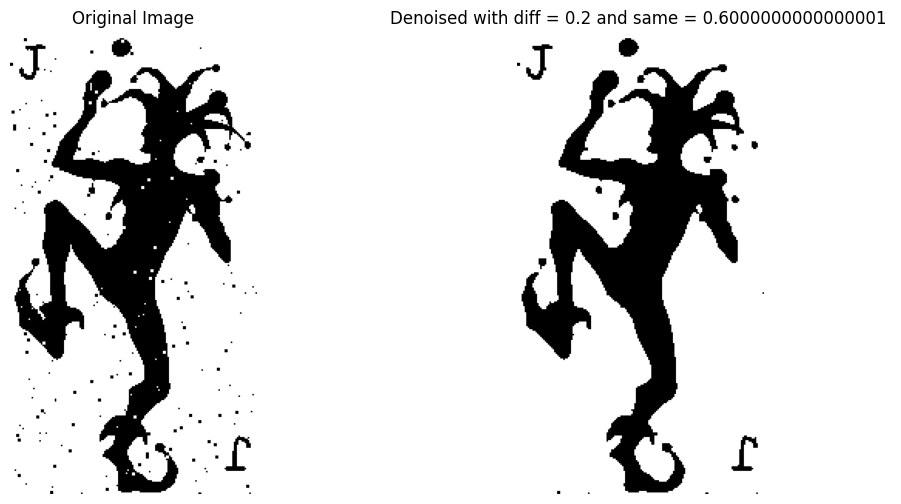

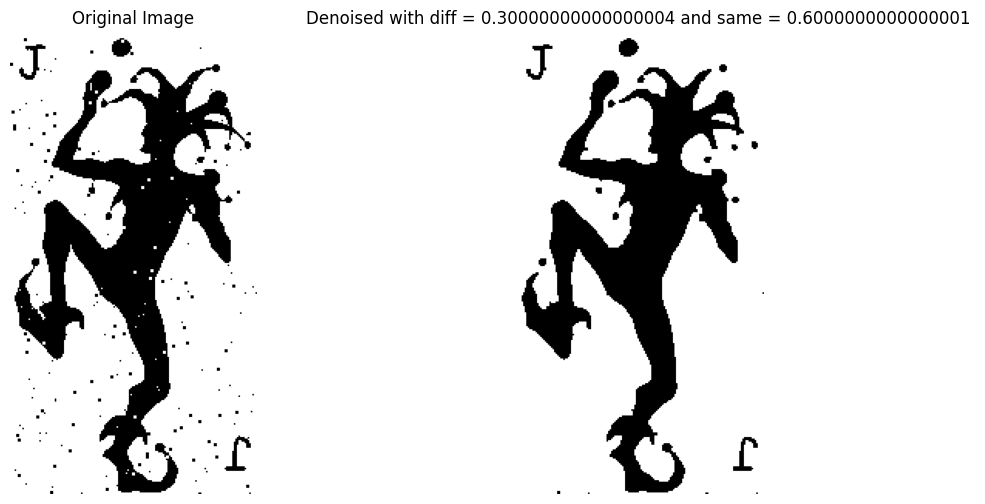

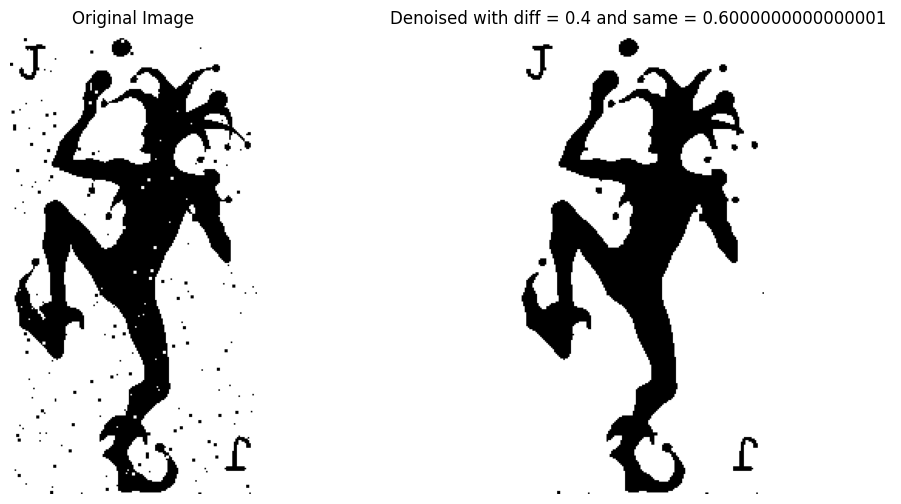

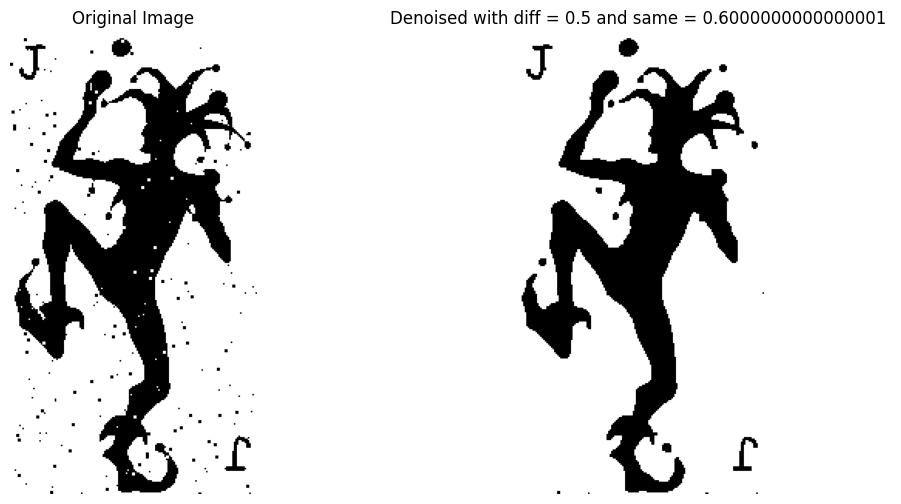

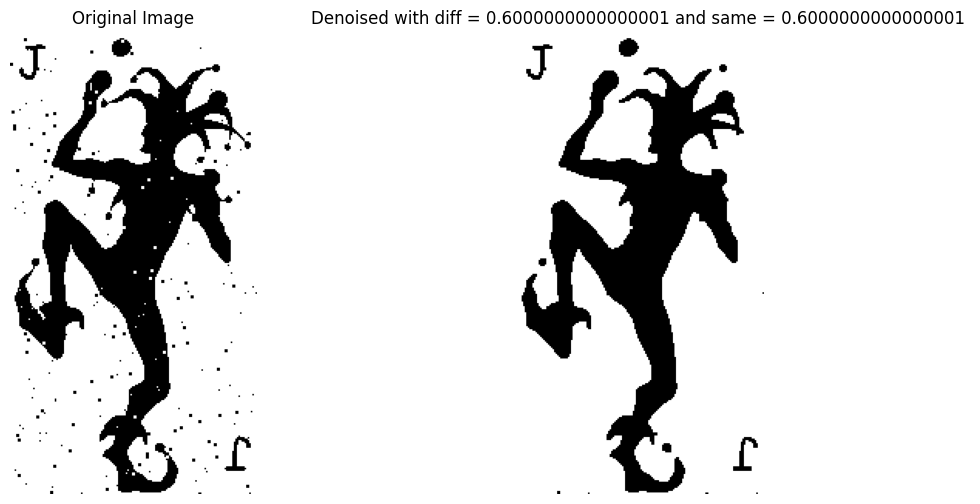

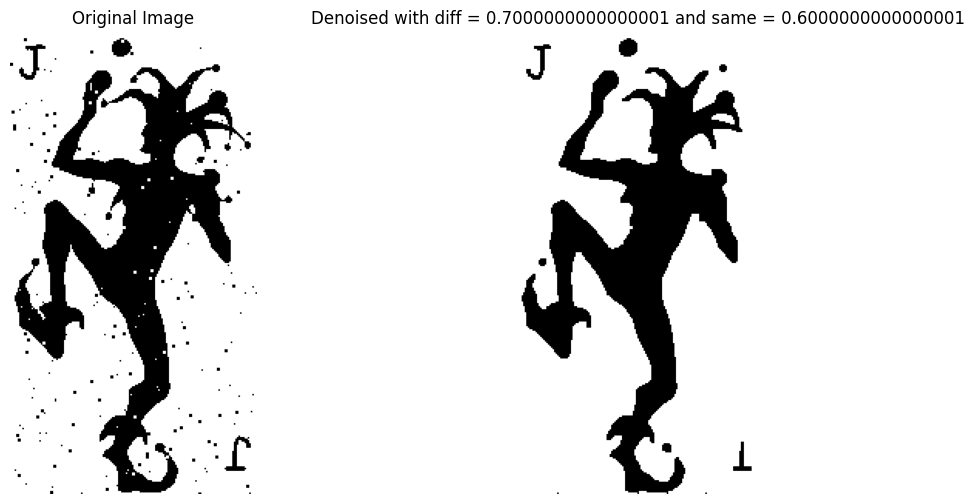

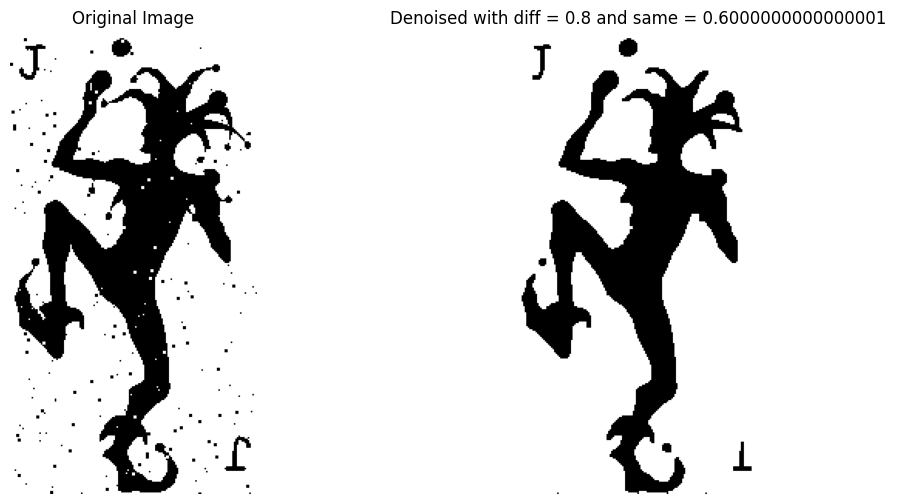

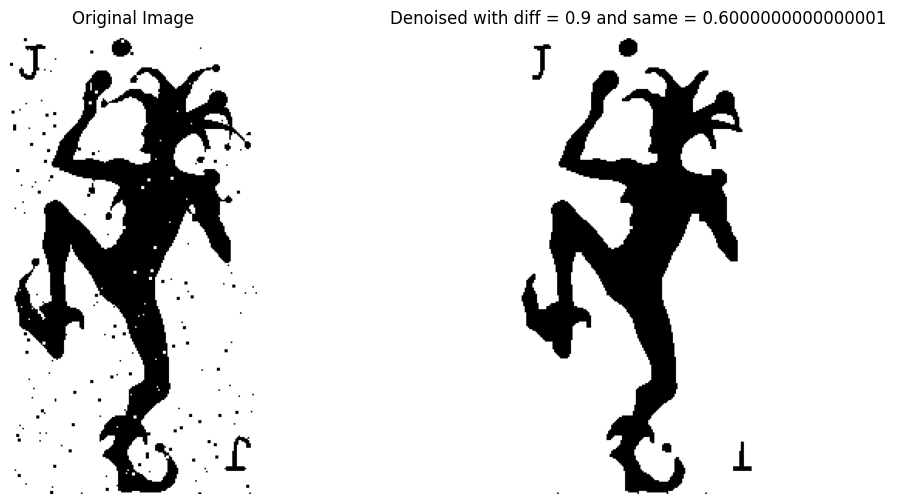

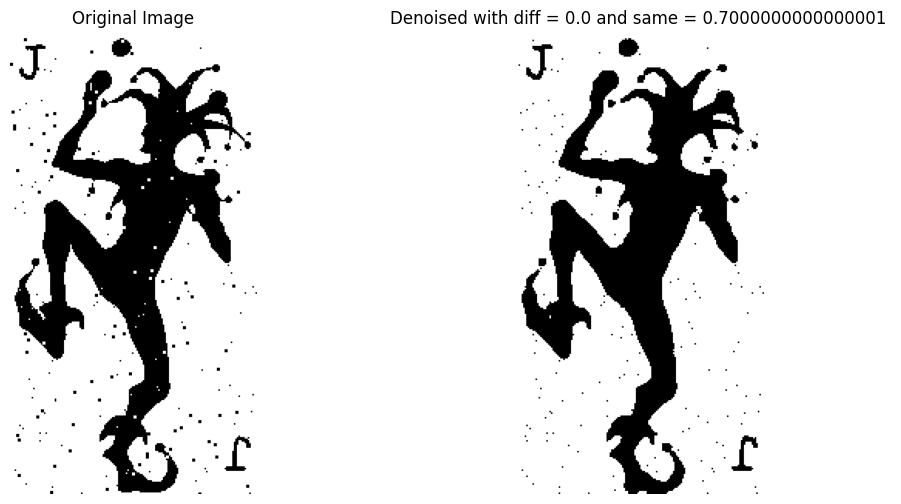

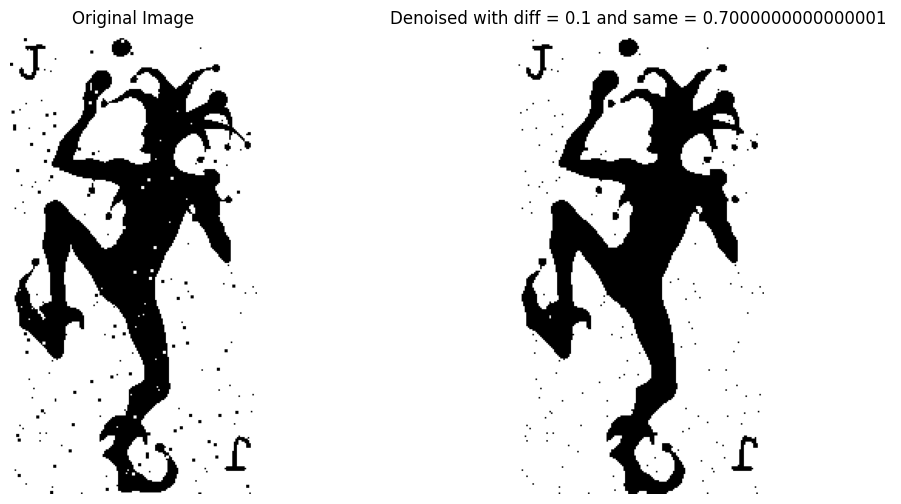

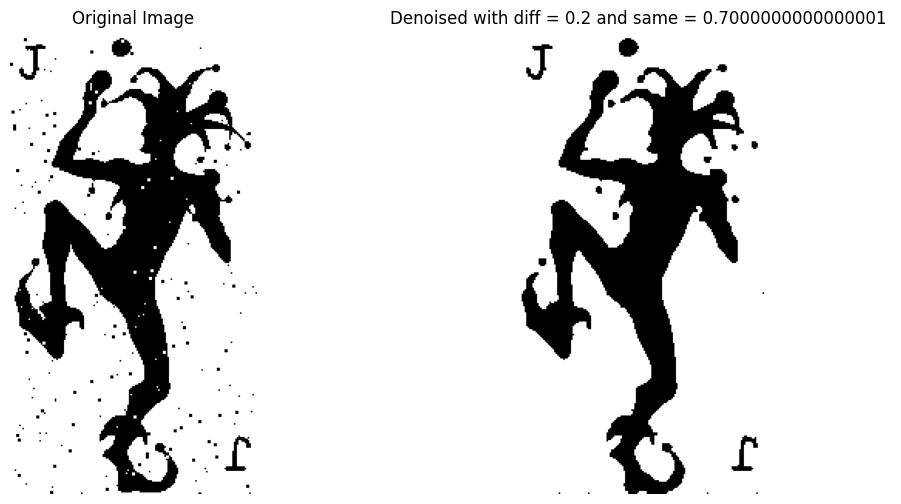

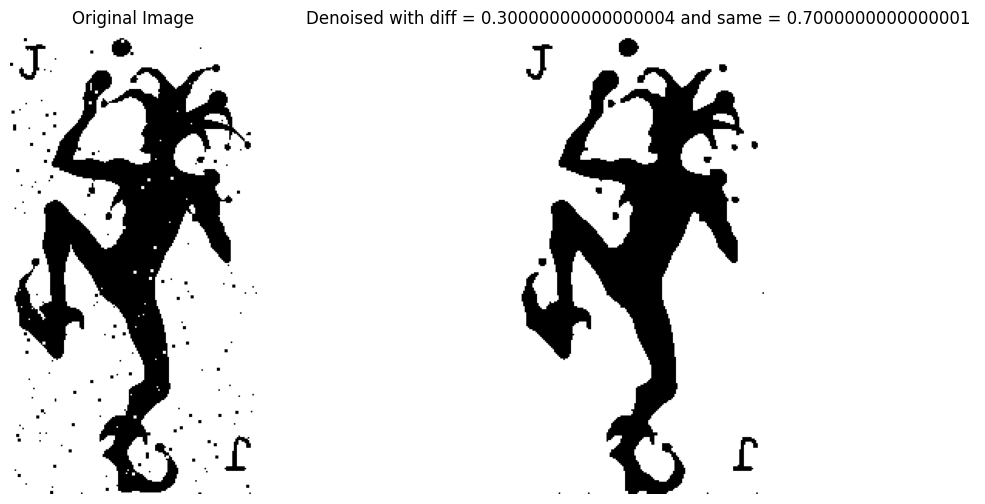

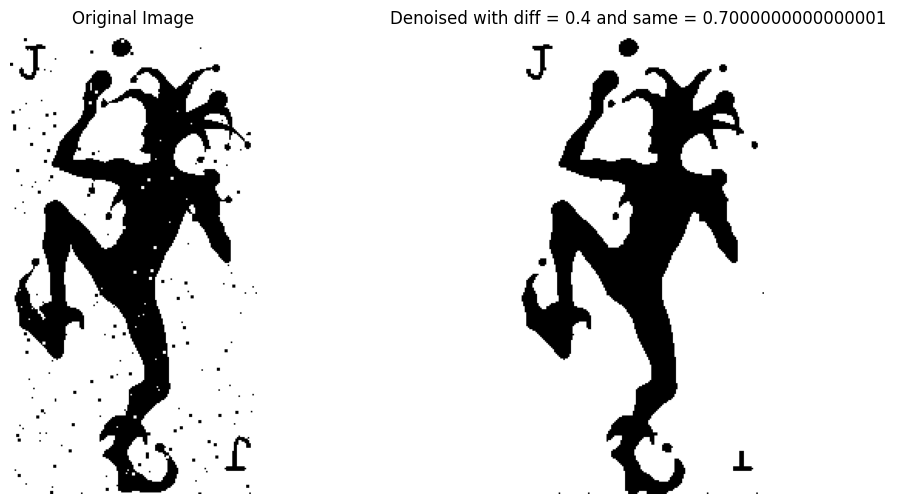

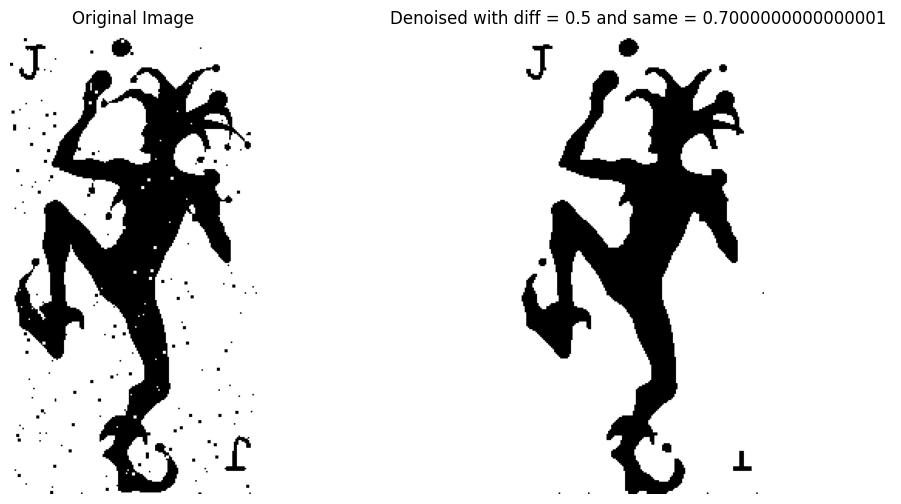

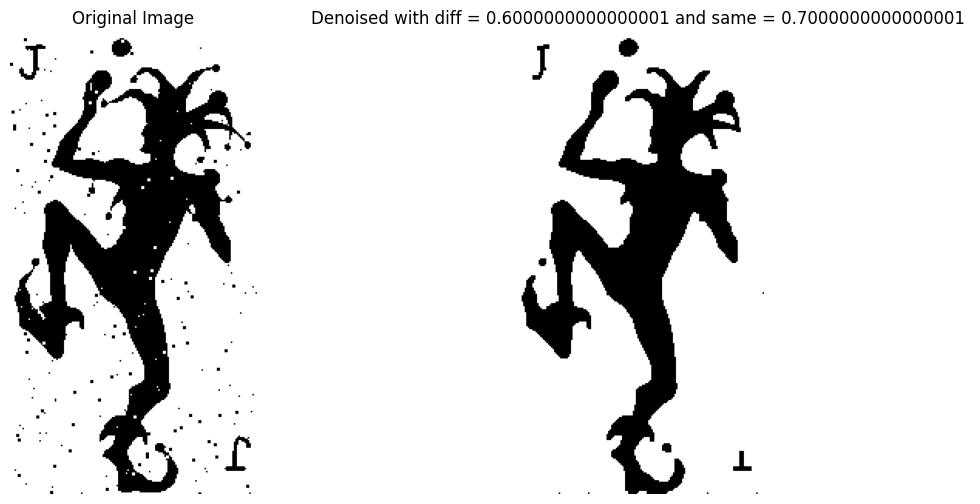

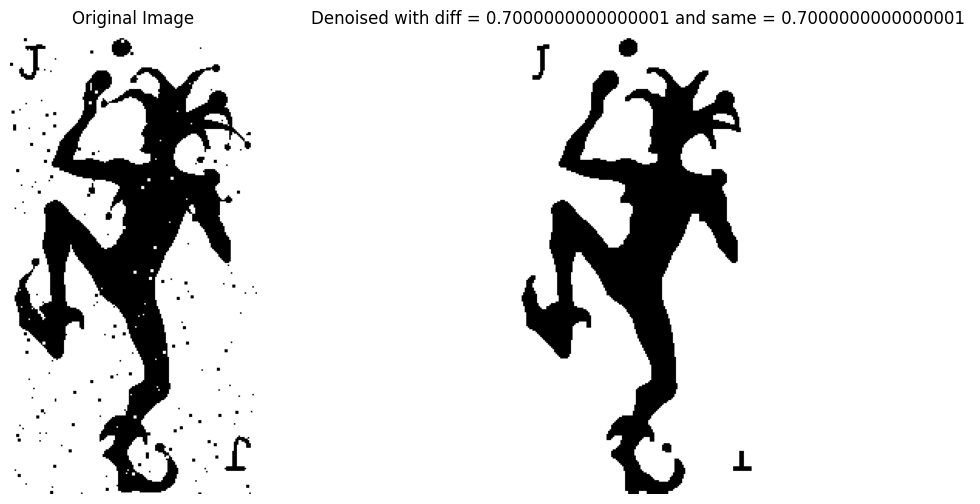

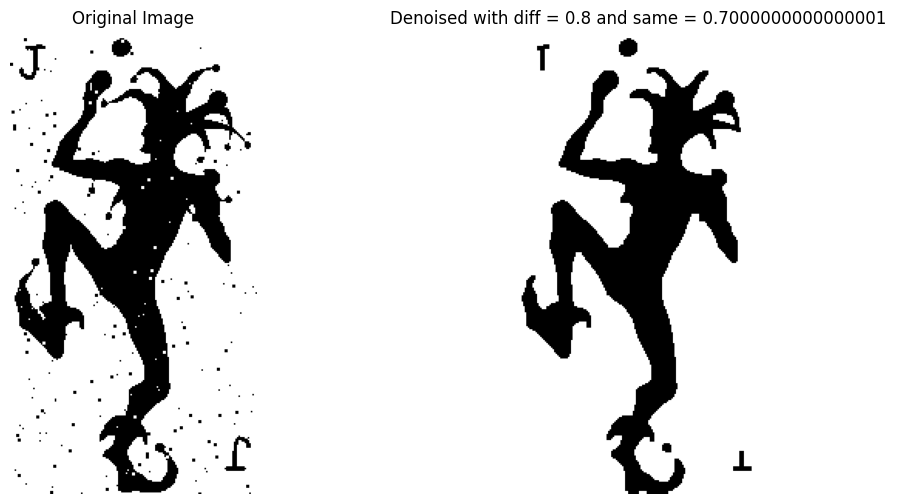

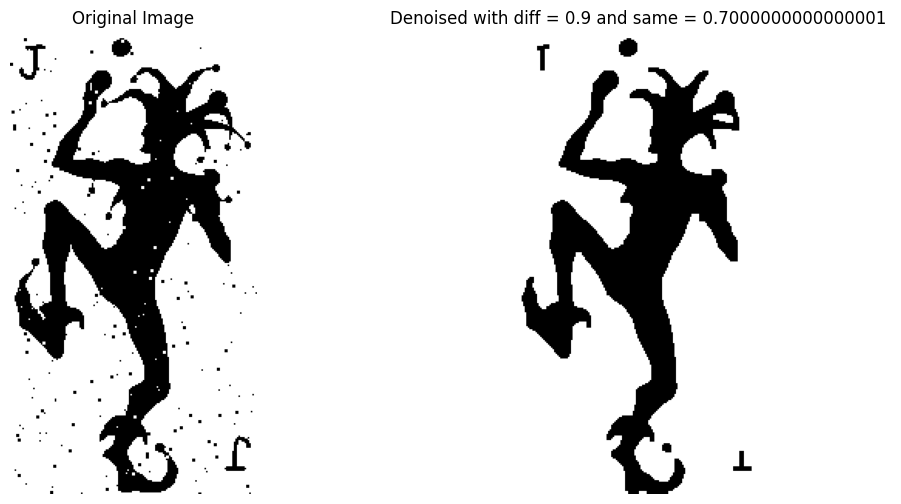

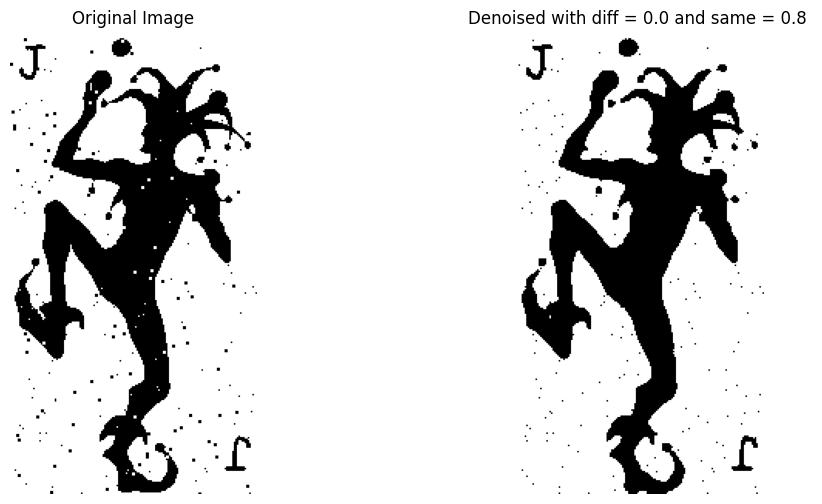

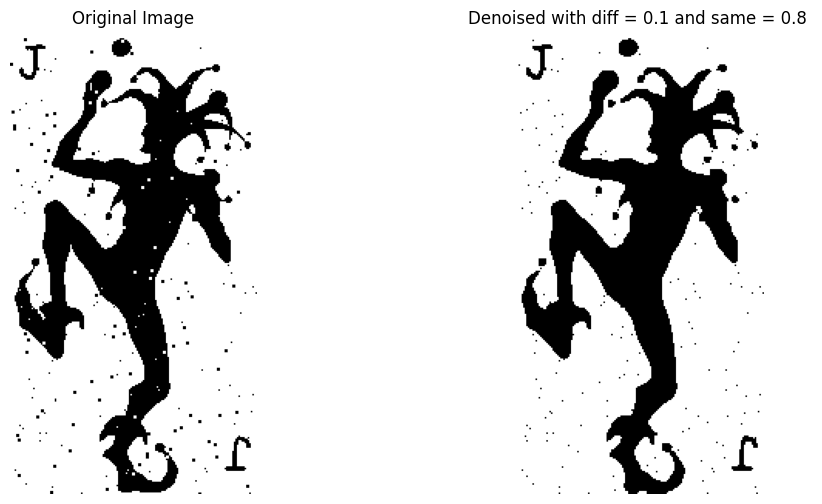

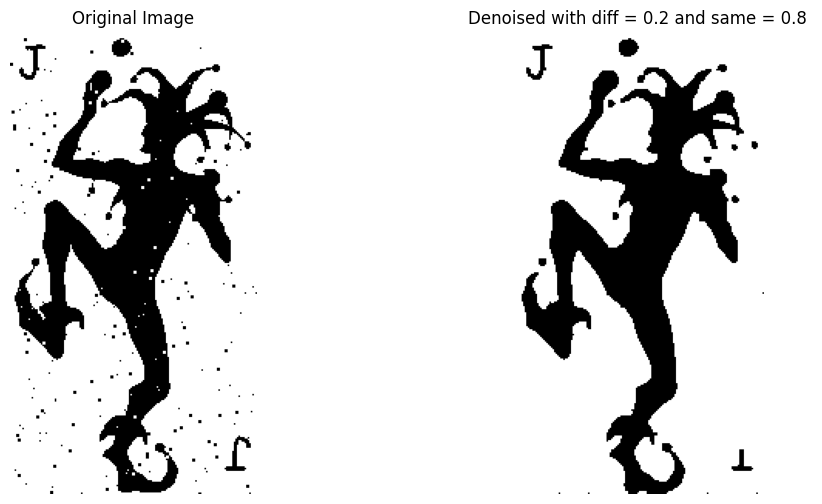

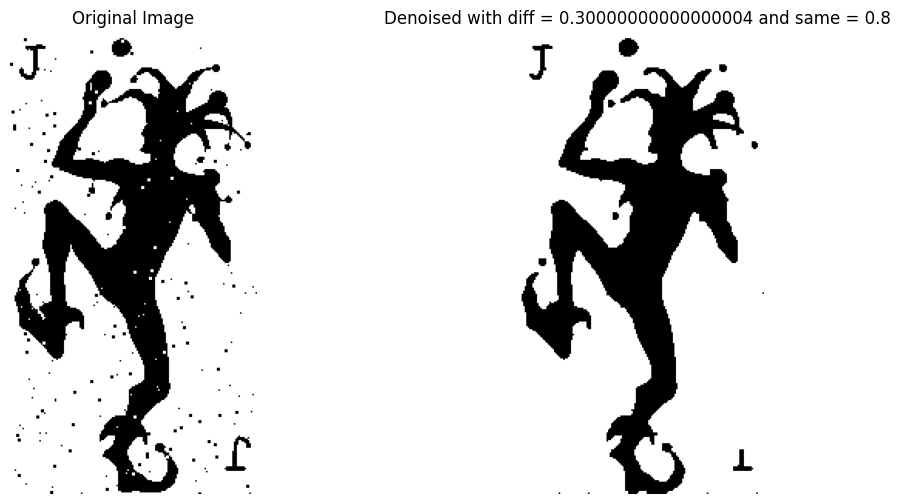

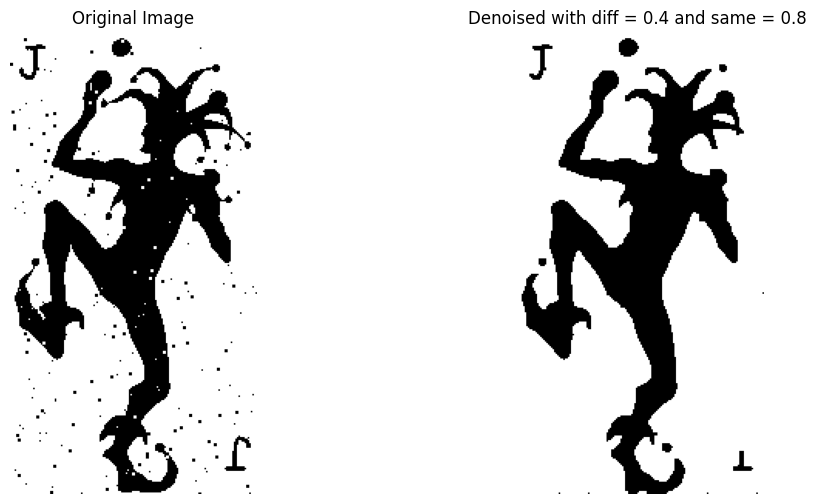

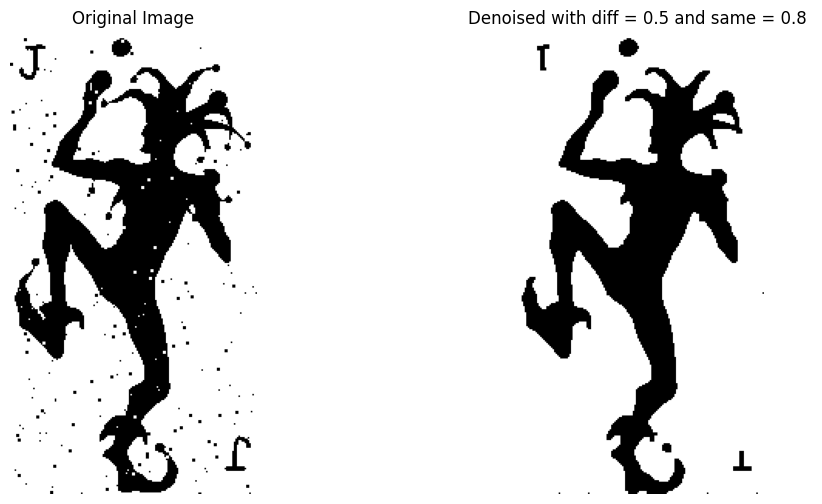

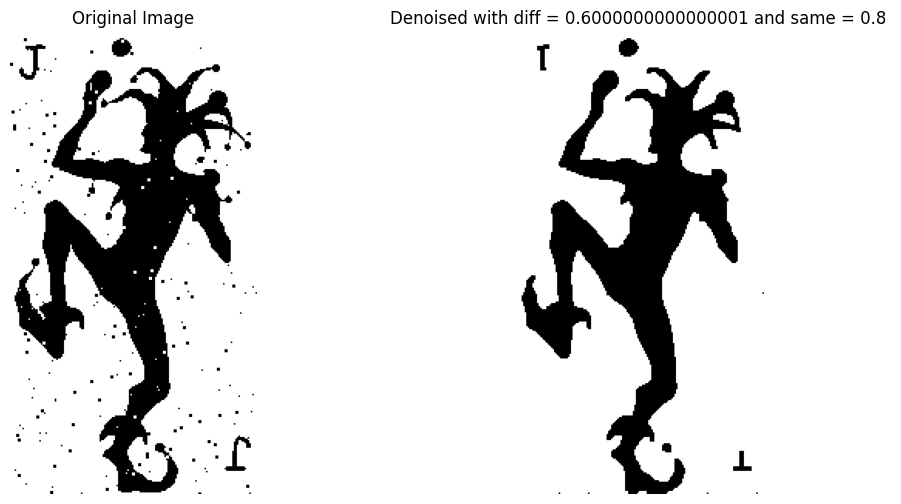

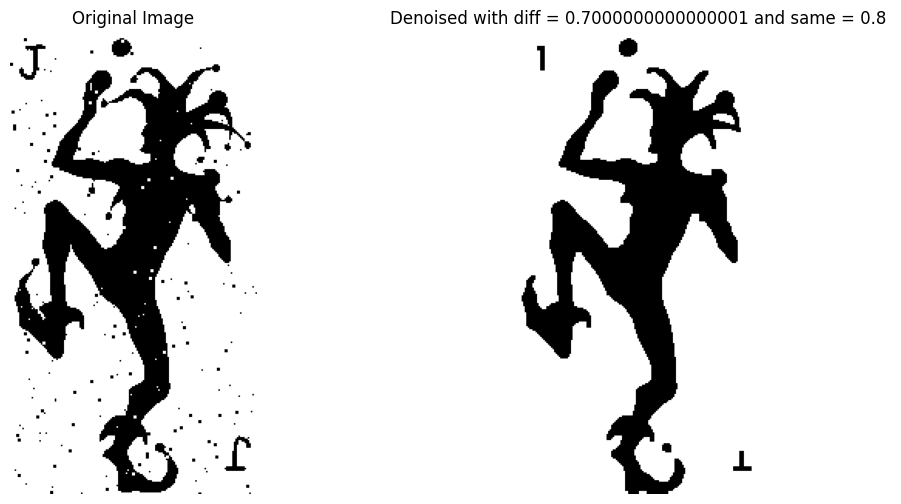

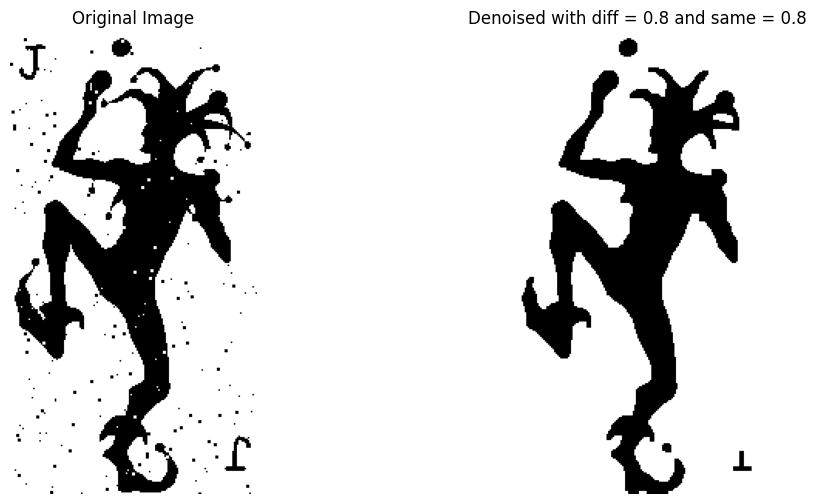

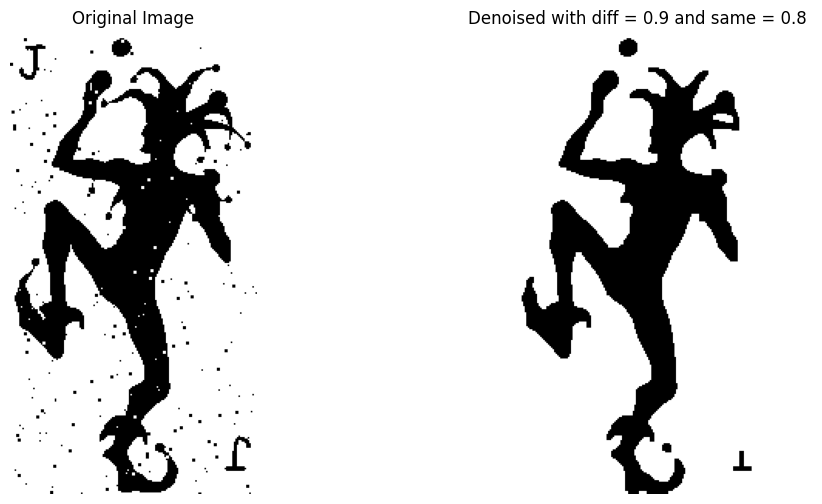

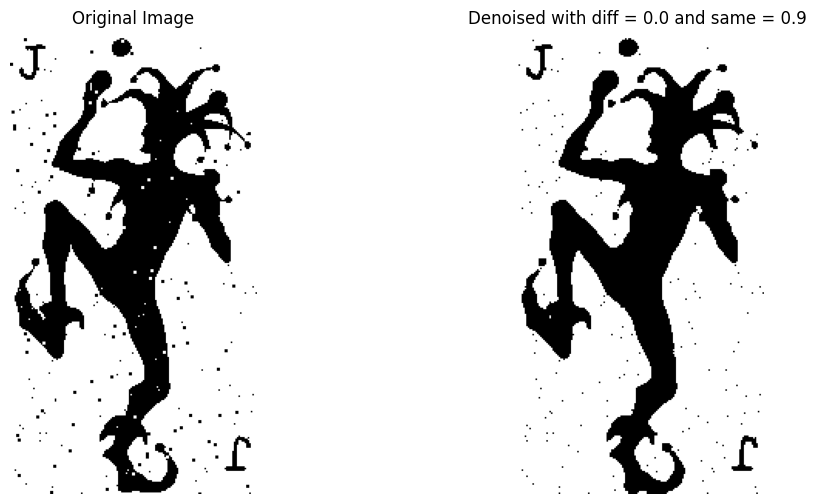

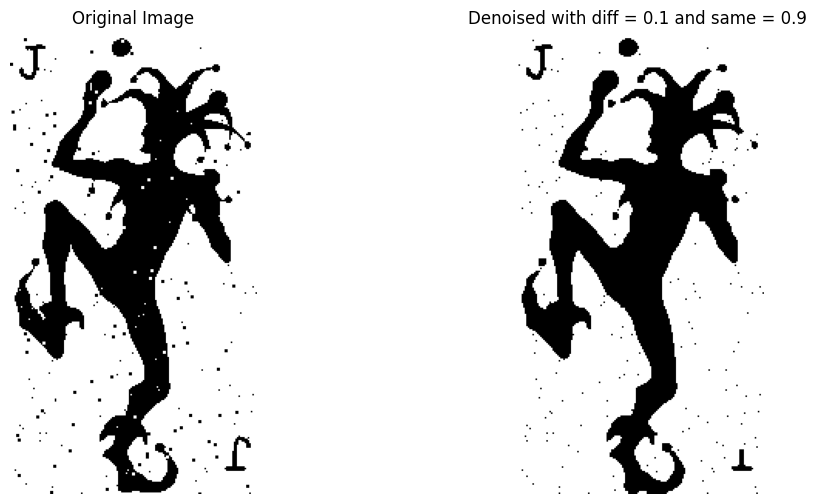

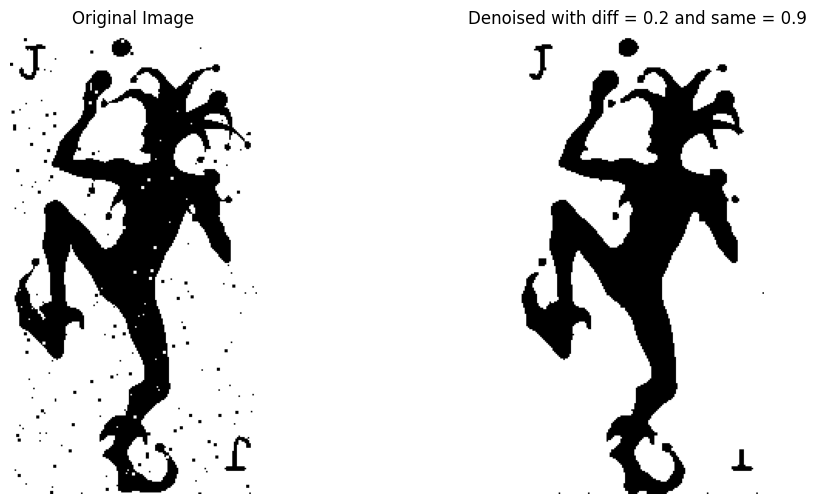

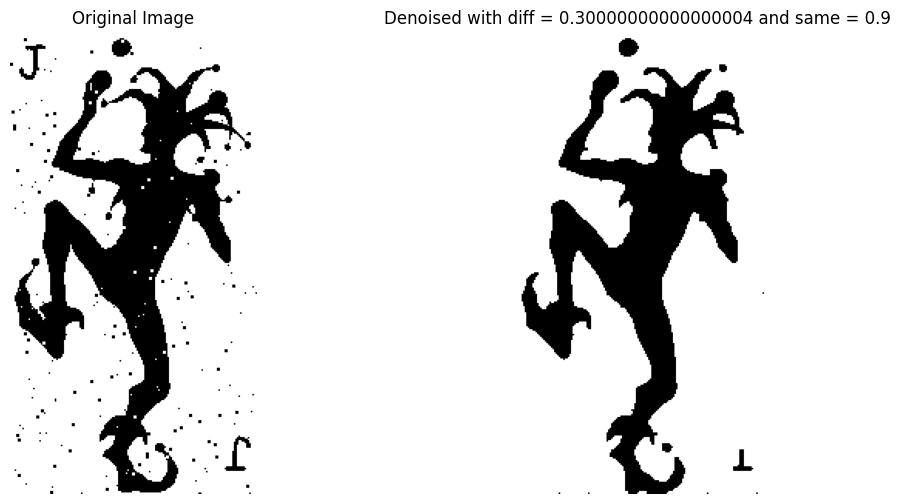

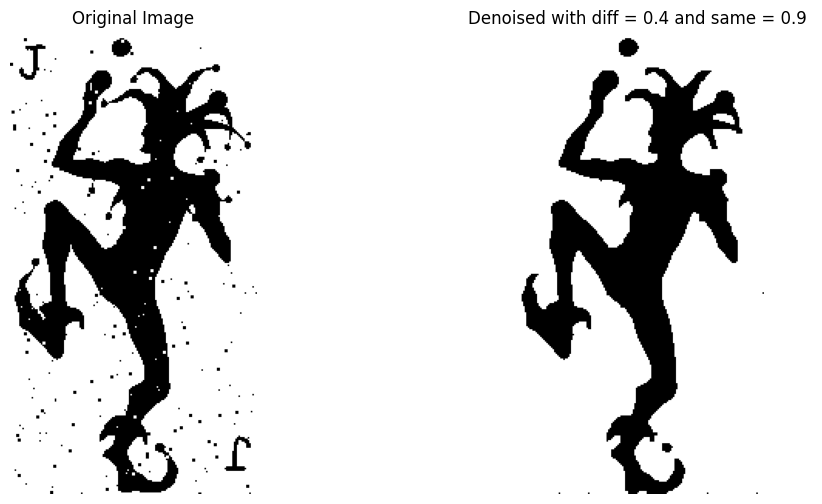

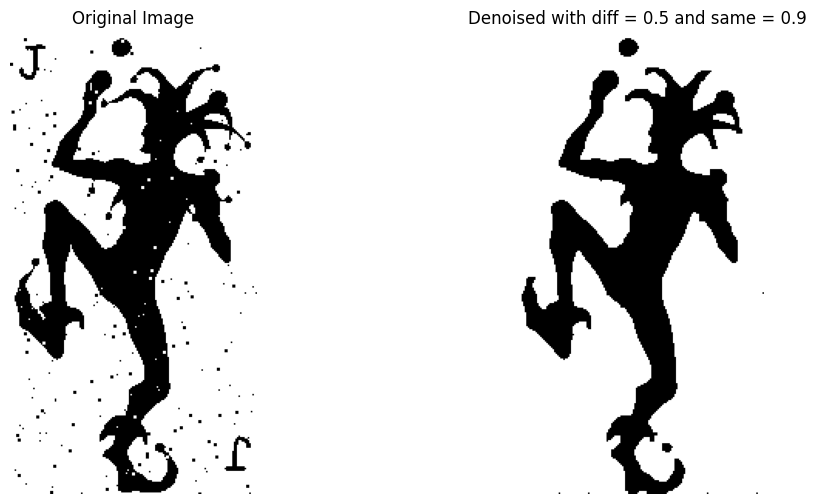

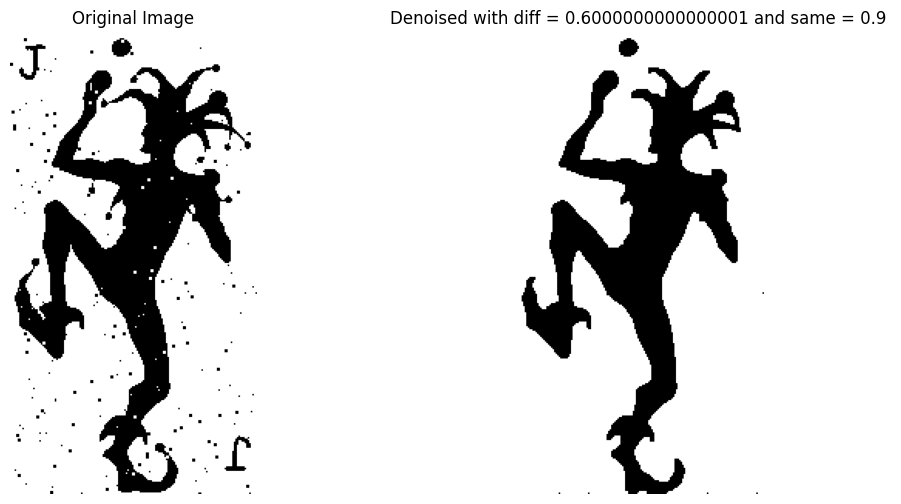

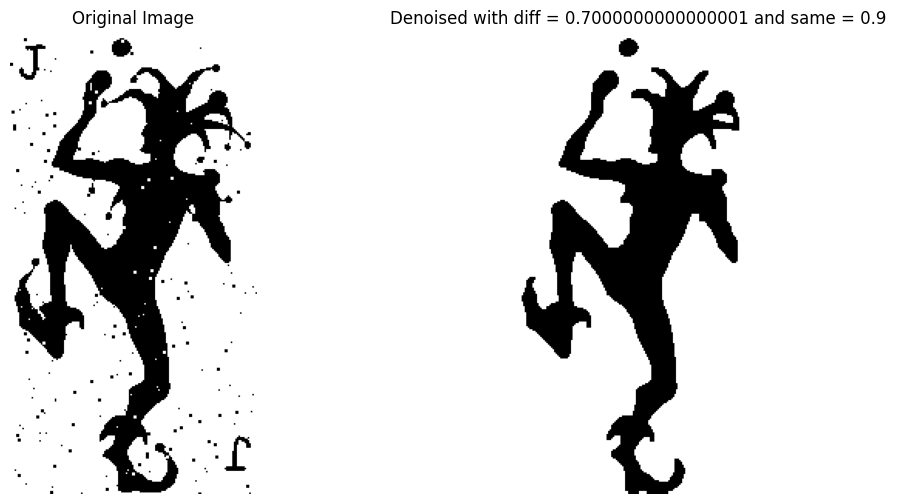

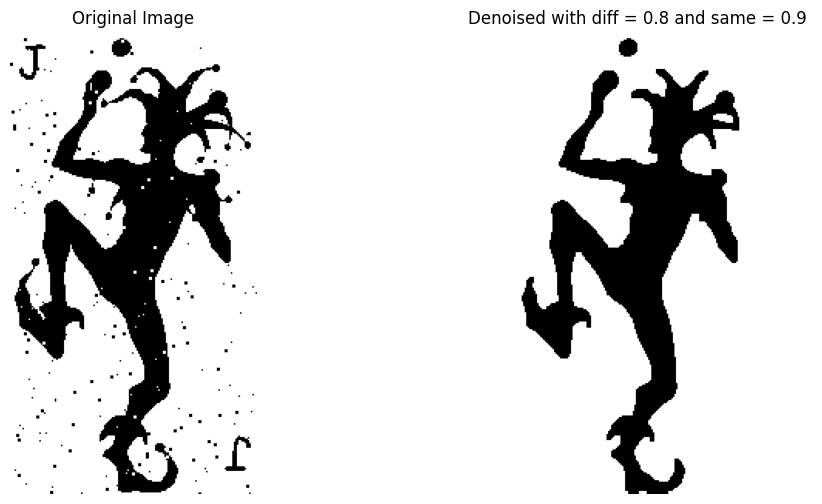

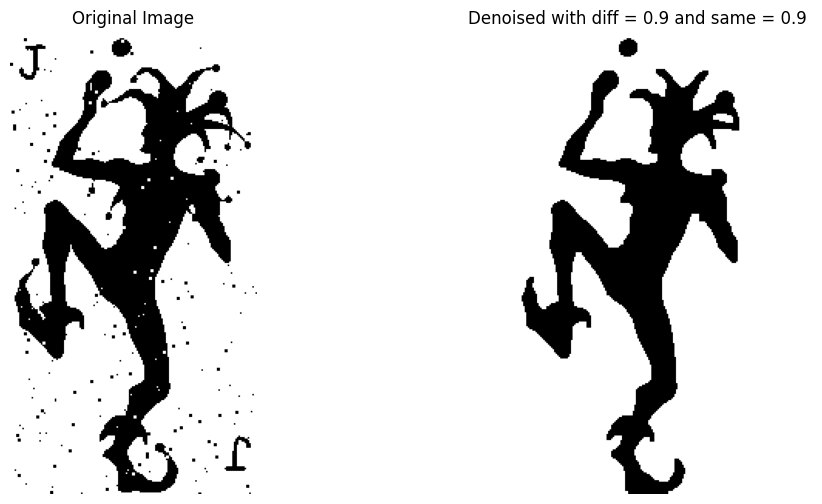

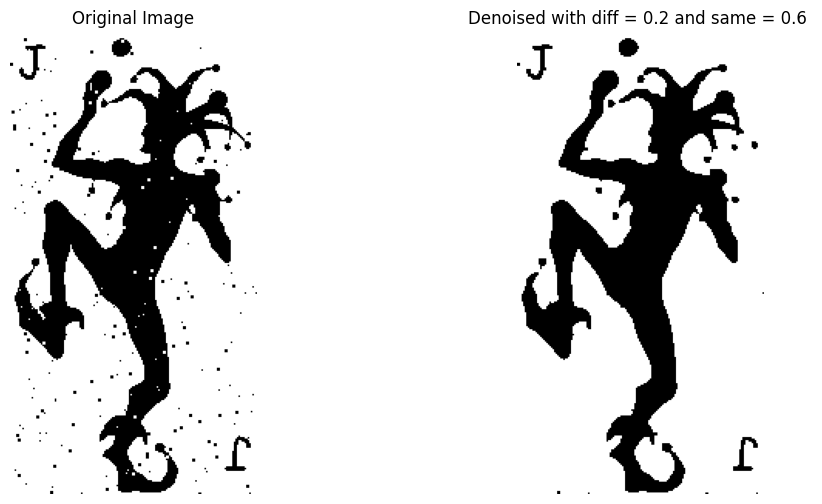

In [16]:
def main():
    image_binary = cv2.imread('./images/noisy_binary_img.png', cv2.IMREAD_GRAYSCALE)
    image_grayscale = cv2.imread('./images/noisy_grayscale_img.png', cv2.IMREAD_GRAYSCALE)

    rho = 0.35
    pairwise_cost_same = np.arange(0.0, 1.0, 0.1) 
    pairwise_cost_diff = np.arange(0.0, 1.0, 0.1)
     
    for i in pairwise_cost_same:
        for j in pairwise_cost_diff:
            binary_img_denoiser(image_binary, rho, i, j)
    """
    Some notes on question 3
    - You can test binary_img_denoiser with the following range
            - pairwise_cost_same: np.arange(0.0, 1, step=0.1)
            - pairwise_cost_diff: np.arange(0.0, 1, step=0.1)
            - you can set rho to 0.35
        for better results you need more fine-grained step (such as 0.05).
    - Display the denoised output images for different values and
        based on these results report what is the impact of each parameter. 
    """
    pairwise_cost_same = 0.6
    pairwise_cost_diff = 0.2
    binary_img_denoiser(image_binary, rho, pairwise_cost_same, pairwise_cost_diff)


main()

In [74]:
def grayscale_img_denoiser(img, rho):
    """

    :param img:
    :param rho:
    :return:
    """
    labels = np.unique(img)

    denoised_img = np.zeros_like(img)
    # Use Alpha expansion binary image for each label

    for label in labels:
        # 1) Define Graph
        g = maxflow.Graph[float]()

        # 2) Add pixels as nodes
        row, col = img.shape  
        nodeids = g.add_grid_nodes((row, col))

        # 3) Compute Unary cost
        unary_cost_source = np.zeros(img.shape)

        unary_cost_source[img == label] = -np.log(1 - rho)
        unary_cost_source[img != label] = -np.log(rho / 2)

        unary_cost_sink = np.zeros(img.shape)

        unary_cost_sink[img == label] = -np.log(rho)
        unary_cost_sink[img != label] = -np.log((1 - rho) / 2)

        # 4) Add terminal edges
        g.add_grid_tedges(nodeids, unary_cost_source, unary_cost_sink)

        # 5) Add Node edges
        pairwise_cost_vertical = np.zeros(img.shape)
        
        # Vertical edges
        shifted_img = img[1:]  # Сдвигаем массив вниз на одну строку
        same_value = (shifted_img == img[:-1])  # Сравниваем текущую и предыдущую строки

        pairwise_cost_vertical[1:] = np.where(same_value, 0, 1)

        structure = np.array([[0, 1, 0], [0, 0, 0], [0, 1, 0]])
        g.add_grid_edges(nodeids, pairwise_cost_vertical, structure, symmetric=False) 

        # Horizontal edges
        # (Keep in mind the structure of neighbourhood and set the weights according to the pairwise potential)
        pairwise_cost_horizontal = np.zeros(img.shape)
        shifted_img_horizontal = img[:, 1:]  # Сдвигаем массив вправо на один столбец
        same_value_horizontal = (shifted_img_horizontal == img[:, :-1])  # Сравниваем текущий и предыдущий столбцы

        pairwise_cost_horizontal[:, 1:] = np.where(same_value_horizontal, 0, 1)

        structure = np.array([[0, 0, 0], [1, 0, 1], [0, 0, 0]])
        g.add_grid_edges(nodeids, pairwise_cost_horizontal, structure, symmetric=False) 

        # 6) Maxflow
        g.maxflow()
        sgm = g.get_grid_segments(nodeids)
        denoised_img[sgm] = label
    
    return denoised_img
    

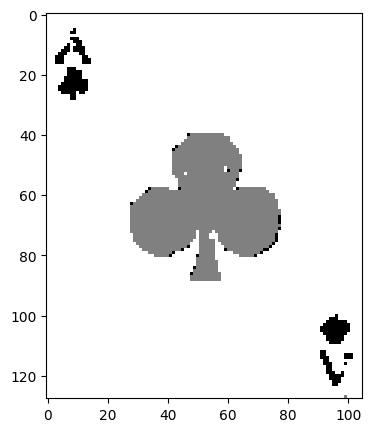

In [75]:
def main():
    image_binary = cv2.imread('./images/noisy_binary_img.png', cv2.IMREAD_GRAYSCALE)
    image_grayscale = cv2.imread('./images/noisy_grayscale_img.png', cv2.IMREAD_GRAYSCALE)

    rho = 0.15
    
    plt.figure(figsize=(7, 5))
    # plt.imshow(image_grayscale, cmap='grey')
    plt.imshow(grayscale_img_denoiser(image_grayscale, rho), cmap='grey')

main()